# Projet télédétection
Audrey Zimmer

Zone d'étude : Bretagne 2023 - 2024

Objectif : 

## 1. Import des librairies

In [50]:
# Librairies python
import sys
sys.path.append('..')
import os
from sklearn.model_selection import train_test_split
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report, \
    accuracy_score
import geopandas as gpd
from osgeo import ogr
from osgeo import gdal
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Librairies personnelles
from libsigma import classification as cla
from libsigma import read_and_write as rw
from libsigma import plots


## Création des dossiers

In [2]:
# Chemin de base (absolu)
my_folder = "/home/onyxia/work/Projet_teledetection"

# Chemins des dossiers à créer (absolus)
results_path = os.path.join(my_folder, "../results")
figure_path = os.path.join(my_folder, "../results/figure")
img_path = os.path.join(my_folder, "img")

# Création des dossiers
os.makedirs(results_path, exist_ok=True)
os.makedirs(figure_path, exist_ok=True)
os.makedirs(img_path, exist_ok=True)

print("Dossiers results, figure et img créés avec succès !")


Dossiers results, figure et img créés avec succès !


## Formatage des données

In [51]:
# Liste des bandes
bandes = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

# Dictionnaire pour stocker les datasets
datasets = {}

# Vérification des dimensions
for bande in bandes:
    chemin = f'/home/onyxia/work/data/projet_eval/bretagne_23-24_{bande}.tif'
    datasets[bande] = gdal.Open(chemin, gdal.GA_ReadOnly)
    print(f"Bande {bande}:")
    print(f"  - Colonnes: {datasets[bande].RasterXSize}")
    print(f"  - Lignes: {datasets[bande].RasterYSize}")
    print(f"  - Nombre de bandes: {datasets[bande].RasterCount}\n")


Bande B02:
  - Colonnes: 1533
  - Lignes: 612
  - Nombre de bandes: 5

Bande B03:
  - Colonnes: 1533
  - Lignes: 612
  - Nombre de bandes: 5

Bande B04:
  - Colonnes: 1533
  - Lignes: 612
  - Nombre de bandes: 5

Bande B05:
  - Colonnes: 1533
  - Lignes: 612
  - Nombre de bandes: 5

Bande B06:
  - Colonnes: 1533
  - Lignes: 612
  - Nombre de bandes: 5

Bande B07:
  - Colonnes: 1533
  - Lignes: 612
  - Nombre de bandes: 5

Bande B08:
  - Colonnes: 1533
  - Lignes: 612
  - Nombre de bandes: 5

Bande B8A:
  - Colonnes: 1533
  - Lignes: 612
  - Nombre de bandes: 5

Bande B11:
  - Colonnes: 1533
  - Lignes: 612
  - Nombre de bandes: 5

Bande B12:
  - Colonnes: 1533
  - Lignes: 612
  - Nombre de bandes: 5



Toutes les bandes obtenues ont la même dimension : 
- 1533 colonnes
- 612 lignes
- 5 bandes

## Analyse des échantillons
### Nombre d'échantillons

In [57]:
# Chemin vers le fichier shapefile
shp_path = '/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp'

# Charger le fichier
gdf = gpd.read_file(shp_path)

# Compter le nombre de polygones par classe
polygon_counts = gdf['strate'].value_counts().reset_index()
polygon_counts.columns = ['Classe', 'Nombre de polygones']

# Convertir 'Classe' en chaîne de caractères pour éviter les conflits de type
polygon_counts['Classe'] = polygon_counts['Classe'].astype(str)

# Créer un DataFrame avec toutes les classes (1, 2, 3, 4), même si elles sont absentes
all_classes = pd.DataFrame({'Classe': ['1', '2', '3', '4']})

# Fusionner avec les comptes réels
polygon_counts = all_classes.merge(polygon_counts, on='Classe', how='left').fillna(0)

# Dictionnaire de correspondance classe/couleur (personnalisable)
color_map = {
    '1': '#F5DEB3',  # Sol nu 
    '2': '#98FB98',  # Herbe 
    '3': '#32CD32',  # Landes 
    '4': '#228B22'   # Arbre 
}

# Créer le diagramme avec Plotly
fig_polygons = px.bar(
    polygon_counts,
    x='Classe',
    y='Nombre de polygones',
    color='Classe',
    color_discrete_map=color_map,
    title='Nombre de polygones par classe',
    labels={'Classe': 'Classe', 'Nombre de polygones': 'Nombre de polygones'},
    category_orders={'Classe': ['1', '2', '3', '4']}
)

# Personnaliser l'affichage des classes sur l'axe x
fig_polygons.update_xaxes(
    type='category',  # Forcer l'affichage en catégories discrètes
    tickvals=['1', '2', '3', '4'],  # Valeurs exactes à afficher
    ticktext=['Sol nu', 'Herbe', 'Landes', 'Arbre']   # Libellés à afficher
)

# Enregistrer la figure
output_polygon_path = '/home/onyxia/work/results/figure/diag_baton_nb_poly_by_class.html'
os.makedirs(os.path.dirname(output_polygon_path), exist_ok=True)
fig_polygons.write_html(output_polygon_path)

# Afficher la figure dans le notebook
fig_polygons.show()

# Vérifier les valeurs uniques de 'strate'
print("Valeurs uniques de 'strate' :", gdf['strate'].unique())

# Vérifier le nombre de polygones par classe
print("Nombre de polygones par classe :\n", gdf['strate'].value_counts())


Valeurs uniques de 'strate' : [3 2 4]
Nombre de polygones par classe :
 strate
3    121
2     86
4     71
Name: count, dtype: int64


La classe 1 (sol nu) est absente des 

### Nombre de pixels par classe

In [6]:
# Rasterisation
# Chemins des fichiers
in_vector = '/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp'
out_image = '/home/onyxia/work/results/PI_strates_bretagne_32630_raster.tif'

# Étendue des polygones
xmin, ymin, xmax, ymax = 433831.49870281, 5362866.42545753, 446289.95490494, 5367061.39833999

# Résolution spatiale (10 mètres pour Sentinel-2)
resolution = 10

# Champ contenant les labels des classes
field_name = 'strate'

# Commande pour rasteriser
cmd = (
    f"gdal_rasterize -a {field_name} "
    f"-tr {resolution} {resolution} "
    f"-te {xmin} {ymin} {xmax} {ymax} "
    "-ot Byte -of GTiff -init 0 "
    f"{in_vector} {out_image}"
)

print(f"Commande exécutée : {cmd}")
os.system(cmd)


Commande exécutée : gdal_rasterize -a strate -tr 10 10 -te 433831.49870281 5362866.42545753 446289.95490494 5367061.39833999 -ot Byte -of GTiff -init 0 /home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp /home/onyxia/work/results/PI_strates_bretagne_32630_raster.tif
0...10...20...30...40...50...60...70...80...90...100 - done.


0

In [7]:
# Vérification des valeurs présentes dans le raster
# Lire le raster rasterisé
raster_ds = gdal.Open(out_image)
band = raster_ds.GetRasterBand(1)
raster_array = band.ReadAsArray()

# Afficher les valeurs uniques et leurs comptes
unique, counts = np.unique(raster_array, return_counts=True)
print("Valeurs uniques dans le raster :", dict(zip(unique, counts)))


Valeurs uniques dans le raster : {np.uint8(0): np.int64(518226), np.uint8(2): np.int64(1044), np.uint8(3): np.int64(1575), np.uint8(4): np.int64(1229)}


In [8]:
# Compter les pixels par classe
unique, counts = np.unique(raster_array, return_counts=True)
pixel_counts = dict(zip(unique, counts))

# Exclure la classe 0 (fond)
pixel_counts.pop(0, None)

# Créer un DataFrame avec toutes les classes (1, 2, 3, 4)
all_classes = pd.DataFrame({'Classe': [1, 2, 3, 4]})

# Fusionner avec les comptes de pixels
pixel_df = pd.merge(
    all_classes,
    pd.DataFrame({'Classe': list(pixel_counts.keys()), 'Nombre de pixels': list(pixel_counts.values())}),
    on='Classe',
    how='left'
).fillna(0)

# Dictionnaire de couleurs
color_map = {
    1: '#F5DEB3',  # Sol nu
    2: '#98FB98',  # Herbe
    3: '#32CD32',  # Landes
    4: '#228B22'   # Arbre
}

# Créer le diagramme
fig_pixels = px.bar(
    pixel_df,
    x='Classe',
    y='Nombre de pixels',
    color='Classe',
    color_discrete_map=color_map,
    title='Nombre de pixels par classe',
    labels={'Classe': 'Classe', 'Nombre de pixels': 'Nombre de pixels'},
    category_orders={'Classe': [1, 2, 3, 4]}
)

# Personnaliser l'axe x
fig_pixels.update_xaxes(
    type='category',
    tickvals=[1, 2, 3, 4],
    ticktext=['1', '2', '3', '4']
)

# Enregistrer la figure
output_pixel_path = '/home/onyxia/work/results/figure/diag_baton_nb_pix_by_class.html'
os.makedirs(os.path.dirname(output_pixel_path), exist_ok=True)
fig_pixels.write_html(output_pixel_path)

# Afficher la figure
fig_pixels.show()


In [10]:
import plotly.graph_objects as go

# Créer le diagramme en utilisant plotly.graph_objects
fig_pixels = go.Figure()

# Ajouter les barres avec les couleurs exactes
for classe in pixel_df['Classe']:
    count = pixel_df[pixel_df['Classe'] == classe]['Nombre de pixels'].values[0]
    fig_pixels.add_trace(go.Bar(
        x=[classe],
        y=[count],
        marker_color=color_map[classe],
        name=str(classe)
    ))

# Mettre à jour la mise en page
fig_pixels.update_layout(
    title='Nombre de pixels par classe',
    xaxis_title='Classe',
    yaxis_title='Nombre de pixels',
    xaxis=dict(
        tickvals=[1, 2, 3, 4],
        ticktext=['Sol nu', 'Herbe', 'Landes', 'Arbre'],
        type='category'
    ),
    showlegend=False
)

# Afficher la figure
fig_pixels.show()

# Enregistrer la figure
output_pixel_path = '/home/onyxia/work/results/figure/diag_baton_nb_pix_by_class.html'
os.makedirs(os.path.dirname(output_pixel_path), exist_ok=True)
fig_pixels.write_html(output_pixel_path)


## Phénologie des strates, mise en évidence des landes

In [58]:
# Liste des bandes
bandes = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

# Liste des dates
dates = ['2024-07-19', '2024-06-07', '2024-04-18', '2024-01-19', '2023-10-08']

# Dictionnaire pour stocker les datasets
datasets = {}

# Chargement des datasets
for bande in bandes:
    chemin = f'/home/onyxia/work/data/projet_eval/bretagne_23-24_{bande}.tif'
    datasets[bande] = gdal.Open(chemin, gdal.GA_ReadOnly)
    if datasets[bande] is None:
        print(f"Erreur: Impossible de charger {chemin}")

# Dimensions spatiales
cols = datasets['B02'].RasterXSize
rows = datasets['B02'].RasterYSize

# Pour chaque date
for date_idx in range(1, len(dates) + 1):
    date = dates[date_idx - 1]

    # Tableau 3D pour stocker toutes les bandes pour cette date
    cube_date = np.zeros((rows, cols, len(bandes)), dtype=np.int16)

    # Pour chaque bande
    for i, bande in enumerate(bandes):
        data = datasets[bande].GetRasterBand(date_idx).ReadAsArray()
        data_filled = np.where(np.isnan(data), -9999, data)  # Remplacer les NaN par -9999
        cube_date[:, :, i] = data_filled.astype(np.int16)

    # Création du fichier de sortie
    chemin_sortie = f'/home/onyxia/work/results/bretagne_{date}_fixed.tif'
    driver = gdal.GetDriverByName('GTiff')
    out_dataset = driver.Create(chemin_sortie, cols, rows, len(bandes), gdal.GDT_Int16)

    # Copie des informations géoréférencées
    out_dataset.SetGeoTransform(datasets['B02'].GetGeoTransform())
    out_dataset.SetProjection(datasets['B02'].GetProjection())

    # Définir la valeur NoData pour chaque bande et écrire les données
    for i in range(len(bandes)):
        out_band = out_dataset.GetRasterBand(i + 1)
        out_band.SetNoDataValue(-9999)  # Définir la valeur NoData
        out_band.WriteArray(cube_date[:, :, i])

    # Fermeture du fichier
    out_dataset = None

    print(f"Image pour la date {date} créée : {chemin_sortie}")


Image pour la date 2024-07-19 créée : /home/onyxia/work/results/bretagne_2024-07-19_fixed.tif
Image pour la date 2024-06-07 créée : /home/onyxia/work/results/bretagne_2024-06-07_fixed.tif
Image pour la date 2024-04-18 créée : /home/onyxia/work/results/bretagne_2024-04-18_fixed.tif
Image pour la date 2024-01-19 créée : /home/onyxia/work/results/bretagne_2024-01-19_fixed.tif
Image pour la date 2023-10-08 créée : /home/onyxia/work/results/bretagne_2023-10-08_fixed.tif


In [59]:
for date in dates:
    chemin_sortie = f'/home/onyxia/work/results/bretagne_{date}_fixed.tif'
    dataset = gdal.Open(chemin_sortie)
    if dataset is not None:
        print(f"Fichier: {chemin_sortie}")
        for band_num in range(1, dataset.RasterCount + 1):
            band = dataset.GetRasterBand(band_num)
            no_data_value = band.GetNoDataValue()
            print(f"  Bande {band_num} - NoData Value: {no_data_value}")

            # Lire les données en masquant les valeurs NoData
            data = band.ReadAsArray()
            masked_data = np.ma.masked_equal(data, no_data_value)
            print(f"  Bande {band_num} - Min: {np.min(masked_data)}, Max: {np.max(masked_data)}, Moyenne: {np.mean(masked_data)}")
    else:
        print(f"Erreur: Impossible de lire le fichier {chemin_sortie}")


Fichier: /home/onyxia/work/results/bretagne_2024-07-19_fixed.tif
  Bande 1 - NoData Value: -9999.0
  Bande 1 - Min: 1, Max: 5648, Moyenne: 1274.136792704389
  Bande 2 - NoData Value: -9999.0
  Bande 2 - Min: 986, Max: 6136, Moyenne: 1516.6220414911204
  Bande 3 - NoData Value: -9999.0
  Bande 3 - Min: 983, Max: 5344, Moyenne: 1436.9411618047038
  Bande 4 - NoData Value: -9999.0
  Bande 4 - Min: 1057, Max: 5077, Moyenne: 1962.7375273318755
  Bande 5 - NoData Value: -9999.0
  Bande 5 - Min: 1018, Max: 6880, Moyenne: 3409.415148525412
  Bande 6 - NoData Value: -9999.0
  Bande 6 - Min: 995, Max: 7693, Moyenne: 3892.917755053064
  Bande 7 - NoData Value: -9999.0
  Bande 7 - Min: 1110, Max: 8184, Moyenne: 4220.729041117807
  Bande 8 - NoData Value: -9999.0
  Bande 8 - Min: 1036, Max: 7859, Moyenne: 4271.8948162764655
  Bande 9 - NoData Value: -9999.0
  Bande 9 - Min: 1144, Max: 5761, Moyenne: 3087.0559076849236
  Bande 10 - NoData Value: -9999.0
  Bande 10 - Min: 1070, Max: 4601, Moyenne: 20

In [60]:
# Calcul ARI

# Chemins des fichiers d'entrée et de sortie
input_folder = '/home/onyxia/work/results/'
output_folder = '/home/onyxia/work/results/'
output_file = os.path.join(output_folder, 'ARI_serie_temp.tif')

# Liste des dates (adapte selon tes fichiers)
#dates = ['2023-10-08', '2024-01-19', '2024-04-18', '2024-06-07', '2024-07-19']
dates = ['2024-07-19', '2024-06-07', '2024-04-18', '2024-01-19', '2023-10-08']

# Lire les dimensions et la projection depuis une image de référence
ref_image_path = os.path.join(input_folder, 'bretagne_2023-10-08_fixed.tif')
ref_ds = gdal.Open(ref_image_path)
cols = ref_ds.RasterXSize
rows = ref_ds.RasterYSize
transform = ref_ds.GetGeoTransform()
projection = ref_ds.GetProjection()

# Créer un fichier de sortie pour ARI
driver = gdal.GetDriverByName('GTiff')
out_ds = driver.Create(output_file, cols, rows, len(dates), gdal.GDT_Float32)
out_ds.SetGeoTransform(transform)
out_ds.SetProjection(projection)

# Définir la valeur NoData
for band in range(1, len(dates) + 1):
    out_band = out_ds.GetRasterBand(band)
    out_band.SetNoDataValue(-9999)

# Calculer ARI pour chaque date
for i, date in enumerate(dates):
    # Chemins des bandes B03 et B05
    b03_path = os.path.join(input_folder, f'bretagne_{date}_fixed.tif')
    b05_path = os.path.join(input_folder, f'bretagne_{date}_fixed.tif')

    # Ouvrir les bandes B03 et B05
    b03_ds = gdal.Open(b03_path)
    b05_ds = gdal.Open(b05_path)

    # Lire les bandes 3 et 5 (adapte les indices selon ton organisation)
    b03_band = b03_ds.GetRasterBand(3)  # Supposons que B03 est la bande 3
    b05_band = b05_ds.GetRasterBand(5)  # Supposons que B05 est la bande 5

    # Lire les données
    b03 = b03_band.ReadAsArray().astype(np.float32)
    b05 = b05_band.ReadAsArray().astype(np.float32)

    # Éviter les divisions par zéro en ajoutant un epsilon
    #epsilon = 1e-10
    #ari = np.where((b03 == 0) | (b05 == 0), np.nan, (1/(b03 + epsilon) - 1/(b05 + epsilon)) / (1/(b03 + epsilon) + 1/(b05 + epsilon)))


    ari = np.where((b03 == 0) | (b05 == 0), np.nan, (1/b03 - 1/b05) / (1/b03 + 1/b05))


    # Remplacer les NaN par la valeur NoData (-9999)
    ari = np.where(np.isnan(ari), -9999, ari)

    # Écrire ARI dans la bande de sortie
    out_band = out_ds.GetRasterBand(i + 1)
    out_band.WriteArray(ari)
    out_band.FlushCache()

# Fermer les fichiers
out_ds = None

print(f"Fichier ARI_serie_temp.tif enregistré avec succès dans {output_folder}")


Fichier ARI_serie_temp.tif enregistré avec succès dans /home/onyxia/work/results/


In [61]:
# Charger le fichier de strates
strates_path = '/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp'
gdf = gpd.read_file(strates_path)

# Lire le fichier ARI_serie_temp.tif
ari_path = '/home/onyxia/work/results/ARI_serie_temp.tif'
ari_ds = gdal.Open(ari_path)
dates = ['2024-07-19', '2024-06-07', '2024-04-18', '2024-01-19', '2023-10-08']

# Préparer les données pour chaque strate
strates = sorted(gdf['strate'].unique())  # Trier les strates pour s'assurer de l'ordre
ari_means = {strate: [] for strate in strates}
ari_stds = {strate: [] for strate in strates}

# Obtenir les informations géométriques et spatiales
transform = ari_ds.GetGeoTransform()
projection = ari_ds.GetProjection()
x_size = ari_ds.RasterXSize
y_size = ari_ds.RasterYSize

# Pour chaque strate
for strate in strates:
    # Filtrer les polygones de la strate
    strate_gdf = gdf[gdf['strate'] == strate]

    # Pour chaque bande (date)
    for band_num in range(1, ari_ds.RasterCount + 1):
        # Lire la bande
        band = ari_ds.GetRasterBand(band_num)
        ari_array = band.ReadAsArray()

        # Créer un masque pour la strate
        rasterized = np.zeros((y_size, x_size), dtype=np.uint8)

        # Créer une couche en mémoire
        mem_drv = ogr.GetDriverByName('Memory')
        mem_ds = mem_drv.CreateDataSource('out')
        mem_layer = mem_ds.CreateLayer('poly', srs=ogr.osr.SpatialReference(wkt=projection), geom_type=ogr.wkbPolygon)

        # Ajouter chaque géométrie à la couche
        for _, row in strate_gdf.iterrows():
            feature = ogr.Feature(mem_layer.GetLayerDefn())
            feature.SetGeometry(ogr.CreateGeometryFromWkb(row.geometry.wkb))
            mem_layer.CreateFeature(feature)
            feature = None

        # Créer un raster en mémoire pour le masque
        mem_raster_ds = gdal.GetDriverByName('MEM').Create('', x_size, y_size, 1, gdal.GDT_Byte)
        mem_raster_ds.SetGeoTransform(transform)
        mem_raster_ds.SetProjection(projection)
        mem_raster_band = mem_raster_ds.GetRasterBand(1)
        mem_raster_band.Fill(0)

        # Rasteriser
        gdal.RasterizeLayer(mem_raster_ds, [1], mem_layer, burn_values=[1], options=["ALL_TOUCHED=TRUE"])

        # Lire le masque rasterisé
        rasterized = mem_raster_ds.GetRasterBand(1).ReadAsArray()

        # Extraire les valeurs ARI pour la strate
        ari_values = ari_array[rasterized == 1]
        ari_values = ari_values[ari_values != -9999]  # Exclure les valeurs NoData

        # Calculer la moyenne et l'écart-type
        if len(ari_values) > 0:
            mean_ari = np.nanmean(ari_values)
            std_ari = np.nanstd(ari_values)
        else:
            mean_ari = np.nan
            std_ari = np.nan

        ari_means[strate].append(mean_ari)
        ari_stds[strate].append(std_ari)

# Créer le dossier s'il n'existe pas
os.makedirs('/home/onyxia/work/results/figure', exist_ok=True)

# Définir les couleurs et les labels pour chaque strate
colors = {
    1: 'rgba(210, 180, 140, 1.0)',  # tan pour sol nu
    2: 'rgba(152, 251, 152, 1.0)',  # palegreen pour herbe
    3: 'rgba(50, 205, 50, 1.0)',   # limegreen pour landes
    4: 'rgba(0, 100, 0, 1.0)'      # darkgreen pour arbre
}

labels = {
    1: 'Sol nu',
    2: 'Herbe',
    3: 'Landes',
    4: 'Arbre'
}

# Créer le graphique avec Plotly
fig = go.Figure()

# Pour chaque strate
for strate in strates:
    means = ari_means[strate]
    stds = ari_stds[strate]
    color = colors.get(strate, 'rgba(128, 128, 128, 1.0)')  # Couleur par défaut si la strate n'est pas définie
    label = labels.get(strate, f'Strate {strate}')

    # Ajouter la ligne de la moyenne
    fig.add_trace(go.Scatter(
        x=dates,
        y=means,
        mode='lines+markers',
        name=label,
        line=dict(color=color, width=3)
    ))

    # Ajouter l'enveloppe de l'écart-type avec une couleur plus claire
    fig.add_trace(go.Scatter(
        x=np.concatenate([dates, dates[::-1]]),
        y=np.concatenate([np.array(means) + np.array(stds), (np.array(means) - np.array(stds))[::-1]]),
        fill='toself',
        fillcolor=color.replace('1.0', '0.3'),  # Couleur plus claire avec alpha=0.3
        line=dict(color='rgba(255,255,255,0)'),
        showlegend=False,
        hoverinfo="skip"
    ))

# Personnaliser le graphique
fig.update_layout(
    title='Série temporelle moyenne de l\'ARI par strate',
    xaxis_title='Date',
    yaxis_title='ARI moyen',
    legend_title='Strates',
    hovermode='x unified',
    width=1200,  # Largeur du graphique
    height=700,  # Hauteur du graphique
    xaxis=dict(
        tickmode='array',
        tickvals=dates,
        ticktext=dates  # Afficher les dates complètes
    )
)

# Enregistrer le graphique en HTML
fig.write_html('/home/onyxia/work/results/figure/ARI_series.html')

# Afficher le graphique
fig.show()


In [ ]:
# Paramètres
input_folder = '/home/onyxia/work/results/'
output_folder = '/home/onyxia/work/results/'
output_file = os.path.join(output_folder, 'ARI_serie_temp.tif')
dates = ['2023-10-08', '2024-01-19', '2024-04-18', '2024-06-07', '2024-07-19']
nodata = -9999
epsilon = 1e-6

# Image de référence
ref_image_path = os.path.join(input_folder, 'bretagne_2023-10-08_fixed.tif')
ref_ds = gdal.Open(ref_image_path)
cols = ref_ds.RasterXSize
rows = ref_ds.RasterYSize
transform = ref_ds.GetGeoTransform()

# Projection forcée EPSG:32630
srs = osr.SpatialReference()
srs.ImportFromEPSG(32630)
projection = srs.ExportToWkt()

# Création du raster de sortie
driver = gdal.GetDriverByName('GTiff')
out_ds = driver.Create(output_file, cols, rows, len(dates), gdal.GDT_Float32)
out_ds.SetGeoTransform(transform)
out_ds.SetProjection(projection)

for i in range(1, len(dates) + 1):
    out_ds.GetRasterBand(i).SetNoDataValue(nodata)

# Boucle de calcul ARI
for i, date in enumerate(dates):
    img_path = os.path.join(input_folder, f'bretagne_{date}_fixed.tif')
    ds = gdal.Open(img_path)

    # Lecture B03 (10m)
    b03 = ds.GetRasterBand(3).ReadAsArray().astype(np.float32)

    # Lecture et rééchantillonnage B05 (20m -> 10m)
    b05_10m_ds = gdal.Warp(
        '',
        ds,
        format='MEM',
        xRes=10,
        yRes=10,
        resampleAlg='bilinear',
        dstSRS=projection
    )
    b05 = b05_10m_ds.GetRasterBand(5).ReadAsArray().astype(np.float32)

    # Calcul ARI
    mask = (b03 > 0) & (b05 > 0)
    ari = np.full(b03.shape, nodata, dtype=np.float32)
    ari[mask] = (
        (1 / (b03[mask] + epsilon) - 1 / (b05[mask] + epsilon)) /
        (1 / (b03[mask] + epsilon) + 1 / (b05[mask] + epsilon))
    )

    # Écriture
    out_band = out_ds.GetRasterBand(i + 1)
    out_band.WriteArray(ari)
    out_band.FlushCache()

# Fermeture
out_ds = None
ref_ds = None
print("✅ ARI_serie_temp.tif généré correctement")


In [10]:
# Recalcul fichiers intermédiaires

import os
import numpy as np
from osgeo import gdal

# Liste des bandes et des dates
bandes = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
dates = ['2023-10-08', '2024-01-19', '2024-04-18', '2024-06-07', '2024-07-19']

# Dossiers
input_folder = '/home/onyxia/work/data/projet_eval/'
output_folder = '/home/onyxia/work/results/'
os.makedirs(output_folder, exist_ok=True)

# Pour chaque date
for date in dates:
    # Tableau 3D pour stocker toutes les bandes (10m)
    cube_date = np.zeros((612, 1533, len(bandes)), dtype=np.int16)

    # Pour chaque bande
    for i, bande in enumerate(bandes):
        # Chemin du fichier source
        chemin = f'{input_folder}bretagne_23-24_{bande}.tif'
        ds = gdal.Open(chemin)

        # Lire la bande (rééchantillonner à 10m si nécessaire)
        if bande in ['B05', 'B06', 'B07', 'B8A', 'B11', 'B12']:  # Bandes à 20m
            warped_ds = gdal.Warp(
                '',
                ds,
                format='MEM',
                xRes=10, yRes=10,
                resampleAlg='bilinear',
                dstSRS='EPSG:32630'
            )
            data = warped_ds.GetRasterBand(1).ReadAsArray()
        else:  # Bandes à 10m
            data = ds.GetRasterBand(1).ReadAsArray()

        # Remplacer les NaN/NoData par -9999
        data_filled = np.where(np.isnan(data), -9999, data)
        cube_date[:, :, i] = data_filled.astype(np.int16)

    # Créer le fichier de sortie
    chemin_sortie = f'{output_folder}bretagne_{date}_fixed.tif'
    driver = gdal.GetDriverByName('GTiff')
    out_ds = driver.Create(chemin_sortie, 1533, 612, len(bandes), gdal.GDT_Int16)

    # Copier les informations géoréférencées
    ref_ds = gdal.Open(f'{input_folder}bretagne_23-24_B02.tif')  # Bande de référence à 10m
    out_ds.SetGeoTransform(ref_ds.GetGeoTransform())
    out_ds.SetProjection(ref_ds.GetProjection())

    # Écrire chaque bande
    for i in range(len(bandes)):
        out_band = out_ds.GetRasterBand(i + 1)
        out_band.SetNoDataValue(-9999)
        out_band.WriteArray(cube_date[:, :, i])

    # Fermer les fichiers
    out_ds = None
    ref_ds = None
    print(f"Fichier {chemin_sortie} créé avec succès.")


Fichier /home/onyxia/work/results/bretagne_2023-10-08_fixed.tif créé avec succès.
Fichier /home/onyxia/work/results/bretagne_2024-01-19_fixed.tif créé avec succès.
Fichier /home/onyxia/work/results/bretagne_2024-04-18_fixed.tif créé avec succès.
Fichier /home/onyxia/work/results/bretagne_2024-06-07_fixed.tif créé avec succès.
Fichier /home/onyxia/work/results/bretagne_2024-07-19_fixed.tif créé avec succès.


In [17]:
# Recalcul ARI
import os
import numpy as np
from osgeo import gdal, osr

# Paramètres
input_folder = '/home/onyxia/work/results/'
output_folder = '/home/onyxia/work/results/'
output_file = os.path.join(output_folder, 'ARI_serie_temp.tif')
dates = ['2023-10-08', '2024-01-19', '2024-04-18', '2024-06-07', '2024-07-19']
nodata = -9999
epsilon = 1e-6

# Image de référence (B03 à 10m)
ref_image_path = os.path.join(input_folder, 'bretagne_2023-10-08_fixed.tif')
ref_ds = gdal.Open(ref_image_path)
cols = ref_ds.RasterXSize
rows = ref_ds.RasterYSize
transform = ref_ds.GetGeoTransform()

# Projection forcée EPSG:32630
srs = osr.SpatialReference()
srs.ImportFromEPSG(32630)
projection = srs.ExportToWkt()

# Création du raster de sortie
driver = gdal.GetDriverByName('GTiff')
out_ds = driver.Create(output_file, cols, rows, len(dates), gdal.GDT_Float32)
out_ds.SetGeoTransform(transform)
out_ds.SetProjection(projection)

for i in range(1, len(dates) + 1):
    out_ds.GetRasterBand(i).SetNoDataValue(nodata)

# Boucle de calcul ARI
for i, date in enumerate(dates):
    print(f"Traitement de la date : {date}")

    # Chemins des fichiers
    img_path = os.path.join(input_folder, f'bretagne_{date}_fixed.tif')
    ds = gdal.Open(img_path)

    # Lecture B03 (10m)
    b03 = ds.GetRasterBand(3).ReadAsArray().astype(np.float32)

    # Lecture B05 (déjà rééchantillonnée à 10m dans le fichier fixed)
    b05 = ds.GetRasterBand(5).ReadAsArray().astype(np.float32)

    # Calcul ARI
    mask = (b03 > 0) & (b05 > 0)
    ari = np.full(b03.shape, nodata, dtype=np.float32)
    ari[mask] = (
        (1 / (b03[mask] + epsilon) - 1 / (b05[mask] + epsilon)) /
        (1 / (b03[mask] + epsilon) + 1 / (b05[mask] + epsilon))
    )

    # Écriture
    out_band = out_ds.GetRasterBand(i + 1)
    out_band.WriteArray(ari)
    out_band.FlushCache()

# Fermeture
out_ds = None
ref_ds = None
print("✅ ARI_serie_temp.tif généré avec succès.")


Traitement de la date : 2023-10-08
Traitement de la date : 2024-01-19
Traitement de la date : 2024-04-18
Traitement de la date : 2024-06-07
Traitement de la date : 2024-07-19
✅ ARI_serie_temp.tif généré avec succès.


In [12]:
# Extraction des moyennes

import os
import numpy as np
import geopandas as gpd
from osgeo import gdal, ogr
import plotly.graph_objects as go

# Charger les strates
strates_path = '/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp'
gdf = gpd.read_file(strates_path)

# Lire le fichier ARI
ari_path = '/home/onyxia/work/results/ARI_serie_temp.tif'
ari_ds = gdal.Open(ari_path)
dates = ['2023-10-08', '2024-01-19', '2024-04-18', '2024-06-07', '2024-07-19']

# Préparer les données
strates = sorted(gdf['strate'].unique())
ari_means = {strate: [] for strate in strates}
ari_stds = {strate: [] for strate in strates}

# Informations spatiales
transform = ari_ds.GetGeoTransform()
projection = ari_ds.GetProjection()
x_size = ari_ds.RasterXSize
y_size = ari_ds.RasterYSize

# Pour chaque strate
for strate in strates:
    strate_gdf = gdf[gdf['strate'] == strate]

    # Pour chaque date
    for band_num in range(1, ari_ds.RasterCount + 1):
        band = ari_ds.GetRasterBand(band_num)
        ari_array = band.ReadAsArray()

        # Masque pour la strate
        mem_drv = ogr.GetDriverByName('Memory')
        mem_ds = mem_drv.CreateDataSource('out')
        mem_layer = mem_ds.CreateLayer('poly', srs=ogr.osr.SpatialReference(wkt=projection), geom_type=ogr.wkbPolygon)

        for _, row in strate_gdf.iterrows():
            feature = ogr.Feature(mem_layer.GetLayerDefn())
            feature.SetGeometry(ogr.CreateGeometryFromWkb(row.geometry.wkb))
            mem_layer.CreateFeature(feature)
            feature = None

        # Rasteriser
        mem_raster_ds = gdal.GetDriverByName('MEM').Create('', x_size, y_size, 1, gdal.GDT_Byte)
        mem_raster_ds.SetGeoTransform(transform)
        mem_raster_ds.SetProjection(projection)
        mem_raster_band = mem_raster_ds.GetRasterBand(1)
        mem_raster_band.Fill(0)
        gdal.RasterizeLayer(mem_raster_ds, [1], mem_layer, burn_values=[1], options=["ALL_TOUCHED=TRUE"])

        # Extraire les valeurs ARI
        rasterized = mem_raster_ds.GetRasterBand(1).ReadAsArray()
        ari_values = ari_array[rasterized == 1]
        ari_values = ari_values[ari_values != nodata]

        # Calculer moyenne et écart-type
        if len(ari_values) > 0:
            mean_ari = np.nanmean(ari_values)
            std_ari = np.nanstd(ari_values)
        else:
            mean_ari = np.nan
            std_ari = np.nan

        ari_means[strate].append(mean_ari)
        ari_stds[strate].append(std_ari)

# Créer le graphique
colors = {
    2: 'rgba(152, 251, 152, 1.0)',  # Herbe
    3: 'rgba(50, 205, 50, 1.0)',   # Landes
    4: 'rgba(0, 100, 0, 1.0)'      # Arbre
}

labels = {
    2: 'Herbe',
    3: 'Landes',
    4: 'Arbre'
}

fig = go.Figure()
for strate in strates:
    means = ari_means[strate]
    stds = ari_stds[strate]
    color = colors.get(strate, 'rgba(128, 128, 128, 1.0)')
    label = labels.get(strate, f'Strate {strate}')

    fig.add_trace(go.Scatter(
        x=dates,
        y=means,
        mode='lines+markers',
        name=label,
        line=dict(color=color, width=3)
    ))

    fig.add_trace(go.Scatter(
        x=np.concatenate([dates, dates[::-1]]),
        y=np.concatenate([np.array(means) + np.array(stds), (np.array(means) - np.array(stds))[::-1]]),
        fill='toself',
        fillcolor=color.replace('1.0', '0.3'),
        line=dict(color='rgba(255,255,255,0)'),
        showlegend=False,
        hoverinfo="skip"
    ))

fig.update_layout(
    title='Série temporelle moyenne de l\'ARI par strate',
    xaxis_title='Date',
    yaxis_title='ARI moyen',
    legend_title='Strates',
    hovermode='x unified',
    width=1200,
    height=700
)

# Enregistrer le graphique
os.makedirs('/home/onyxia/work/results/figure', exist_ok=True)
fig.write_html('/home/onyxia/work/results/figure/ARI_series.html')
fig.show()


Warning 1: DeprecationWarning: 'Memory' driver is deprecated since GDAL 3.11. Use 'MEM' onwards. Further messages of this type will be suppressed.


In [15]:
for date in dates:
    img_path = os.path.join(input_folder, f'bretagne_{date}_fixed.tif')
    ds = gdal.Open(img_path)
    print(f"\nFichier : {img_path}")
    for band_num in [3, 5]:  # B03 et B05
        band = ds.GetRasterBand(band_num)
        data = band.ReadAsArray()
        print(f"Bande {band_num} - Min: {np.min(data)}, Max: {np.max(data)}, Moyenne: {np.mean(data)}")



Fichier : /home/onyxia/work/results/bretagne_2023-10-08_fixed.tif
Bande 3 - Min: -9999, Max: 5344, Moyenne: -856.5464945491134
Bande 5 - Min: -9999, Max: 6880, Moyenne: 720.346168604428

Fichier : /home/onyxia/work/results/bretagne_2024-01-19_fixed.tif
Bande 3 - Min: -9999, Max: 7612, Moyenne: -690.5572236504952
Bande 5 - Min: -9999, Max: 7742, Moyenne: 547.4915699917715

Fichier : /home/onyxia/work/results/bretagne_2024-04-18_fixed.tif
Bande 3 - Min: -9999, Max: 5444, Moyenne: -744.5758562176774
Bande 5 - Min: -9999, Max: 5983, Moyenne: 771.0757123245036

Fichier : /home/onyxia/work/results/bretagne_2024-06-07_fixed.tif
Bande 3 - Min: -9999, Max: 9712, Moyenne: -431.54654997463217
Bande 5 - Min: -9999, Max: 8595, Moyenne: 1364.837506235371

Fichier : /home/onyxia/work/results/bretagne_2024-07-19_fixed.tif
Bande 3 - Min: -9999, Max: 5564, Moyenne: -822.4384179851545
Bande 5 - Min: -9999, Max: 6909, Moyenne: 1210.62644053055


In [14]:
# Liste des bandes et des dates
bandes = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
dates = ['2023-10-08', '2024-01-19', '2024-04-18', '2024-06-07', '2024-07-19']

# Dictionnaire pour stocker les datasets par bande
datasets = {bande: gdal.Open(f'/home/onyxia/work/data/projet_eval/bretagne_23-24_{bande}.tif') for bande in bandes}

# Pour chaque date
for date_idx, date in enumerate(dates, start=1):  # start=1 car les bandes commencent à 1
    # Tableau 3D pour stocker toutes les bandes pour cette date
    cube_date = np.zeros((612, 1533, len(bandes)), dtype=np.int16)

    # Pour chaque bande
    for i, bande in enumerate(bandes):
        # Lire la bande pour cette date (chaque fichier a 5 bandes temporelles)
        data = datasets[bande].GetRasterBand(date_idx).ReadAsArray()
        data_filled = np.where(np.isnan(data), -9999, data)
        cube_date[:, :, i] = data_filled.astype(np.int16)

    # Création du fichier de sortie
    chemin_sortie = f'/home/onyxia/work/results/bretagne_{date}_fixed.tif'
    driver = gdal.GetDriverByName('GTiff')
    out_dataset = driver.Create(chemin_sortie, 1533, 612, len(bandes), gdal.GDT_Int16)

    # Copie des informations géoréférencées (depuis B02, qui est à 10m)
    out_dataset.SetGeoTransform(datasets['B02'].GetGeoTransform())
    out_dataset.SetProjection(datasets['B02'].GetProjection())

    # Écrire chaque bande
    for i in range(len(bandes)):
        out_band = out_dataset.GetRasterBand(i + 1)
        out_band.SetNoDataValue(-9999)
        out_band.WriteArray(cube_date[:, :, i])

    # Fermer le fichier
    out_dataset = None
    print(f"Fichier {chemin_sortie} créé avec succès.")


Fichier /home/onyxia/work/results/bretagne_2023-10-08_fixed.tif créé avec succès.
Fichier /home/onyxia/work/results/bretagne_2024-01-19_fixed.tif créé avec succès.
Fichier /home/onyxia/work/results/bretagne_2024-04-18_fixed.tif créé avec succès.
Fichier /home/onyxia/work/results/bretagne_2024-06-07_fixed.tif créé avec succès.
Fichier /home/onyxia/work/results/bretagne_2024-07-19_fixed.tif créé avec succès.


In [16]:
for date in dates:
    img_path = f'/home/onyxia/work/results/bretagne_{date}_fixed.tif'
    ds = gdal.Open(img_path)
    b03 = ds.GetRasterBand(3).ReadAsArray()
    b05 = ds.GetRasterBand(5).ReadAsArray()
    print(f"\n{date} - B03: Min={np.min(b03)}, Max={np.max(b03)}, Moyenne={np.mean(b03)}")
    print(f"{date} - B05: Min={np.min(b05)}, Max={np.max(b05)}, Moyenne={np.mean(b05)}")



2023-10-08 - B03: Min=-9999, Max=5344, Moyenne=-856.5464945491134
2023-10-08 - B05: Min=-9999, Max=6880, Moyenne=720.346168604428

2024-01-19 - B03: Min=-9999, Max=7612, Moyenne=-690.5572236504952
2024-01-19 - B05: Min=-9999, Max=7742, Moyenne=547.4915699917715

2024-04-18 - B03: Min=-9999, Max=5444, Moyenne=-744.5758562176774
2024-04-18 - B05: Min=-9999, Max=5983, Moyenne=771.0757123245036

2024-06-07 - B03: Min=-9999, Max=9712, Moyenne=-431.54654997463217
2024-06-07 - B05: Min=-9999, Max=8595, Moyenne=1364.837506235371

2024-07-19 - B03: Min=-9999, Max=5564, Moyenne=-822.4384179851545
2024-07-19 - B05: Min=-9999, Max=6909, Moyenne=1210.62644053055


In [20]:


dates = ['2023-10-08', '2024-01-19', '2024-04-18', '2024-06-07', '2024-07-19']

for date in dates:
    img_path = f'/home/onyxia/work/results/bretagne_{date}_fixed.tif'
    ds = gdal.Open(img_path)

    b03 = ds.GetRasterBand(3).ReadAsArray()
    b05 = ds.GetRasterBand(5).ReadAsArray()

    # Masquer les valeurs NoData
    b03_masked = b03[b03 != -9999]
    b05_masked = b05[b05 != -9999]

    print(f"\n{date} :")
    print(f"  B03 - Min: {np.min(b03_masked):.2f}, Max: {np.max(b03_masked):.2f}, Moyenne: {np.mean(b03_masked):.2f}")
    print(f"  B05 - Min: {np.min(b05_masked):.2f}, Max: {np.max(b05_masked):.2f}, Moyenne: {np.mean(b05_masked):.2f}")



2023-10-08 :
  B03 - Min: 983.00, Max: 5344.00, Moyenne: 1436.94
  B05 - Min: 1018.00, Max: 6880.00, Moyenne: 3409.42

2024-01-19 :
  B03 - Min: 888.00, Max: 7612.00, Moyenne: 1644.59
  B05 - Min: 916.00, Max: 7742.00, Moyenne: 3193.20

2024-04-18 :
  B03 - Min: 1029.00, Max: 5444.00, Moyenne: 1577.00
  B05 - Min: 1092.00, Max: 5983.00, Moyenne: 3472.87

2024-06-07 :
  B03 - Min: 927.00, Max: 9712.00, Moyenne: 1968.56
  B05 - Min: 1149.00, Max: 8595.00, Moyenne: 4215.58

2024-07-19 :
  B03 - Min: 1067.00, Max: 5564.00, Moyenne: 1479.61
  B05 - Min: 1034.00, Max: 6909.00, Moyenne: 4022.69


In [11]:
import os
import numpy as np
from osgeo import gdal, osr

# Paramètres
input_folder = '/home/onyxia/work/results/'
output_folder = '/home/onyxia/work/results/'
output_file = os.path.join(output_folder, 'ARI_serie_temp.tif')
dates = ['2023-10-08', '2024-01-19', '2024-04-18', '2024-06-07', '2024-07-19']
nodata = -9999
epsilon = 1e-6

# Image de référence
ref_image_path = os.path.join(input_folder, 'bretagne_2023-10-08_fixed.tif')
ref_ds = gdal.Open(ref_image_path)
cols = ref_ds.RasterXSize
rows = ref_ds.RasterYSize
transform = ref_ds.GetGeoTransform()

# Projection forcée EPSG:32630
srs = osr.SpatialReference()
srs.ImportFromEPSG(32630)
projection = srs.ExportToWkt()

# Création du raster de sortie
driver = gdal.GetDriverByName('GTiff')
out_ds = driver.Create(output_file, cols, rows, len(dates), gdal.GDT_Float32)
out_ds.SetGeoTransform(transform)
out_ds.SetProjection(projection)

for i in range(1, len(dates) + 1):
    out_ds.GetRasterBand(i).SetNoDataValue(nodata)

# Boucle de calcul ARI
for i, date in enumerate(dates):
    print(f"Traitement de la date : {date}")

    # Chemins des fichiers
    img_path = os.path.join(input_folder, f'bretagne_{date}_fixed.tif')
    ds = gdal.Open(img_path)

    # Lecture B03 et B05
    b03 = ds.GetRasterBand(3).ReadAsArray().astype(np.float32)
    b05 = ds.GetRasterBand(5).ReadAsArray().astype(np.float32)

    # Masque pour les valeurs ≤ 0
    mask = (b03 > 0) & (b05 > 0)

    # Calcul ARI
    ari = np.full(b03.shape, nodata, dtype=np.float32)
    ari[mask] = (
        (1 / (b03[mask] + epsilon) - 1 / (b05[mask] + epsilon)) /
        (1 / (b03[mask] + epsilon) + 1 / (b05[mask] + epsilon))
    )

    # Écriture
    out_band = out_ds.GetRasterBand(i + 1)
    out_band.WriteArray(ari)
    out_band.FlushCache()

# Fermeture
out_ds = None
ref_ds = None
print("✅ ARI_serie_temp.tif généré avec succès.")


Traitement de la date : 2023-10-08
Traitement de la date : 2024-01-19
Traitement de la date : 2024-04-18
Traitement de la date : 2024-06-07
Traitement de la date : 2024-07-19
✅ ARI_serie_temp.tif généré avec succès.


In [17]:
## 
# Liste des bandes et des dates
bandes = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
dates = ['2023-10-08', '2024-01-19', '2024-04-18', '2024-06-07', '2024-07-19']

# Dictionnaire pour stocker les datasets par bande
datasets = {bande: gdal.Open(f'/home/onyxia/work/data/projet_eval/bretagne_23-24_{bande}.tif') for bande in bandes}

# Pour chaque date
for date_idx, date in enumerate(dates, start=1):  # start=1 car les bandes commencent à 1
    # Tableau 3D pour stocker toutes les bandes pour cette date
    cube_date = np.zeros((612, 1533, len(bandes)), dtype=np.int16)

    # Pour chaque bande
    for i, bande in enumerate(bandes):
        # Lire la bande pour cette date (chaque fichier a 5 bandes temporelles)
        data = datasets[bande].GetRasterBand(date_idx).ReadAsArray()
        data_filled = np.where(np.isnan(data), -9999, data)
        cube_date[:, :, i] = data_filled.astype(np.int16)

    # Création du fichier de sortie
    chemin_sortie = f'/home/onyxia/work/results/bretagne_{date}_fixed.tif'
    driver = gdal.GetDriverByName('GTiff')
    out_dataset = driver.Create(chemin_sortie, 1533, 612, len(bandes), gdal.GDT_Int16)

    # Copie des informations géoréférencées (depuis B02, qui est à 10m)
    out_dataset.SetGeoTransform(datasets['B02'].GetGeoTransform())
    out_dataset.SetProjection(datasets['B02'].GetProjection())

    # Écrire chaque bande
    for i in range(len(bandes)):
        out_band = out_dataset.GetRasterBand(i + 1)
        out_band.SetNoDataValue(-9999)
        out_band.WriteArray(cube_date[:, :, i])

    # Fermer le fichier
    out_dataset = None
    print(f"Fichier {chemin_sortie} créé avec succès.")


Fichier /home/onyxia/work/results/bretagne_2023-10-08_fixed.tif créé avec succès.
Fichier /home/onyxia/work/results/bretagne_2024-01-19_fixed.tif créé avec succès.
Fichier /home/onyxia/work/results/bretagne_2024-04-18_fixed.tif créé avec succès.
Fichier /home/onyxia/work/results/bretagne_2024-06-07_fixed.tif créé avec succès.
Fichier /home/onyxia/work/results/bretagne_2024-07-19_fixed.tif créé avec succès.


In [18]:
for date in dates:
    img_path = f'/home/onyxia/work/results/bretagne_{date}_fixed.tif'
    ds = gdal.Open(img_path)
    b03 = ds.GetRasterBand(3).ReadAsArray()
    b05 = ds.GetRasterBand(5).ReadAsArray()

    # Masquer les valeurs NoData
    b03_masked = b03[b03 != -9999]
    b05_masked = b05[b05 != -9999]

    print(f"\n{date} :")
    print(f"  B03 - Min: {np.min(b03_masked):.2f}, Max: {np.max(b03_masked):.2f}, Moyenne: {np.mean(b03_masked):.2f}")
    print(f"  B05 - Min: {np.min(b05_masked):.2f}, Max: {np.max(b05_masked):.2f}, Moyenne: {np.mean(b05_masked):.2f}")



2023-10-08 :
  B03 - Min: 983.00, Max: 5344.00, Moyenne: 1436.94
  B05 - Min: 1018.00, Max: 6880.00, Moyenne: 3409.42

2024-01-19 :
  B03 - Min: 888.00, Max: 7612.00, Moyenne: 1644.59
  B05 - Min: 916.00, Max: 7742.00, Moyenne: 3193.20

2024-04-18 :
  B03 - Min: 1029.00, Max: 5444.00, Moyenne: 1577.00
  B05 - Min: 1092.00, Max: 5983.00, Moyenne: 3472.87

2024-06-07 :
  B03 - Min: 927.00, Max: 9712.00, Moyenne: 1968.56
  B05 - Min: 1149.00, Max: 8595.00, Moyenne: 4215.58

2024-07-19 :
  B03 - Min: 1067.00, Max: 5564.00, Moyenne: 1479.61
  B05 - Min: 1034.00, Max: 6909.00, Moyenne: 4022.69


In [19]:
import os
import numpy as np
from osgeo import gdal, osr

# Paramètres
input_folder = '/home/onyxia/work/results/'
output_folder = '/home/onyxia/work/results/'
output_file = os.path.join(output_folder, 'ARI_serie_temp.tif')
dates = ['2023-10-08', '2024-01-19', '2024-04-18', '2024-06-07', '2024-07-19']
nodata = -9999
epsilon = 1e-6

# Image de référence
ref_image_path = os.path.join(input_folder, 'bretagne_2023-10-08_fixed.tif')
ref_ds = gdal.Open(ref_image_path)
cols = ref_ds.RasterXSize
rows = ref_ds.RasterYSize
transform = ref_ds.GetGeoTransform()

# Projection forcée EPSG:32630
srs = osr.SpatialReference()
srs.ImportFromEPSG(32630)
projection = srs.ExportToWkt()

# Création du raster de sortie
driver = gdal.GetDriverByName('GTiff')
out_ds = driver.Create(output_file, cols, rows, len(dates), gdal.GDT_Float32)
out_ds.SetGeoTransform(transform)
out_ds.SetProjection(projection)

for i in range(1, len(dates) + 1):
    out_ds.GetRasterBand(i).SetNoDataValue(nodata)

# Boucle de calcul ARI
for i, date in enumerate(dates):
    print(f"Traitement de la date : {date}")

    # Chemins des fichiers
    img_path = os.path.join(input_folder, f'bretagne_{date}_fixed.tif')
    ds = gdal.Open(img_path)

    # Lecture B03 et B05
    b03 = ds.GetRasterBand(3).ReadAsArray().astype(np.float32)
    b05 = ds.GetRasterBand(5).ReadAsArray().astype(np.float32)

    # Masque pour les valeurs ≤ 0
    mask = (b03 > 0) & (b05 > 0)

    # Calcul ARI
    ari = np.full(b03.shape, nodata, dtype=np.float32)
    ari[mask] = (
        (1 / (b03[mask] + epsilon) - 1 / (b05[mask] + epsilon)) /
        (1 / (b03[mask] + epsilon) + 1 / (b05[mask] + epsilon))
    )

    # Écriture
    out_band = out_ds.GetRasterBand(i + 1)
    out_band.WriteArray(ari)
    out_band.FlushCache()

# Fermeture
out_ds = None
ref_ds = None
print("✅ ARI_serie_temp.tif généré avec succès.")


Traitement de la date : 2023-10-08
Traitement de la date : 2024-01-19
Traitement de la date : 2024-04-18
Traitement de la date : 2024-06-07
Traitement de la date : 2024-07-19
✅ ARI_serie_temp.tif généré avec succès.


In [21]:
# Charger les strates
strates_path = '/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp'
gdf = gpd.read_file(strates_path)

# Lire le fichier ARI
ari_path = '/home/onyxia/work/results/ARI_serie_temp.tif'
ari_ds = gdal.Open(ari_path)
dates = ['2023-10-08', '2024-01-19', '2024-04-18', '2024-06-07', '2024-07-19']

# Préparer les données
strates = sorted(gdf['strate'].unique())
ari_means = {strate: [] for strate in strates}
ari_stds = {strate: [] for strate in strates}

# Informations spatiales
transform = ari_ds.GetGeoTransform()
projection = ari_ds.GetProjection()
x_size = ari_ds.RasterXSize
y_size = ari_ds.RasterYSize

# Pour chaque strate
for strate in strates:
    strate_gdf = gdf[gdf['strate'] == strate]

    # Pour chaque date
    for band_num in range(1, ari_ds.RasterCount + 1):
        band = ari_ds.GetRasterBand(band_num)
        ari_array = band.ReadAsArray()

        # Masque pour la strate
        mem_drv = ogr.GetDriverByName('Memory')
        mem_ds = mem_drv.CreateDataSource('out')
        mem_layer = mem_ds.CreateLayer('poly', srs=ogr.osr.SpatialReference(wkt=projection), geom_type=ogr.wkbPolygon)

        for _, row in strate_gdf.iterrows():
            feature = ogr.Feature(mem_layer.GetLayerDefn())
            feature.SetGeometry(ogr.CreateGeometryFromWkb(row.geometry.wkb))
            mem_layer.CreateFeature(feature)
            feature = None

        # Rasteriser
        mem_raster_ds = gdal.GetDriverByName('MEM').Create('', x_size, y_size, 1, gdal.GDT_Byte)
        mem_raster_ds.SetGeoTransform(transform)
        mem_raster_ds.SetProjection(projection)
        mem_raster_band = mem_raster_ds.GetRasterBand(1)
        mem_raster_band.Fill(0)
        gdal.RasterizeLayer(mem_raster_ds, [1], mem_layer, burn_values=[1], options=["ALL_TOUCHED=TRUE"])

        # Extraire les valeurs ARI
        rasterized = mem_raster_ds.GetRasterBand(1).ReadAsArray()
        ari_values = ari_array[rasterized == 1]
        ari_values = ari_values[ari_values != nodata]

        # Calculer moyenne et écart-type
        if len(ari_values) > 0:
            mean_ari = np.nanmean(ari_values)
            std_ari = np.nanstd(ari_values)
        else:
            mean_ari = np.nan
            std_ari = np.nan

        ari_means[strate].append(mean_ari)
        ari_stds[strate].append(std_ari)

# Créer le graphique
colors = {
    2: 'rgba(152, 251, 152, 1.0)',  # Herbe
    3: 'rgba(50, 205, 50, 1.0)',   # Landes
    4: 'rgba(0, 100, 0, 1.0)'      # Arbre
}

labels = {
    2: 'Herbe',
    3: 'Landes',
    4: 'Arbre'
}

fig = go.Figure()
for strate in strates:
    means = ari_means[strate]
    stds = ari_stds[strate]
    color = colors.get(strate, 'rgba(128, 128, 128, 1.0)')
    label = labels.get(strate, f'Strate {strate}')

    fig.add_trace(go.Scatter(
        x=dates,
        y=means,
        mode='lines+markers',
        name=label,
        line=dict(color=color, width=3)
    ))

    fig.add_trace(go.Scatter(
        x=np.concatenate([dates, dates[::-1]]),
        y=np.concatenate([np.array(means) + np.array(stds), (np.array(means) - np.array(stds))[::-1]]),
        fill='toself',
        fillcolor=color.replace('1.0', '0.3'),
        line=dict(color='rgba(255,255,255,0)'),
        showlegend=False,
        hoverinfo="skip"
    ))

fig.update_layout(
    title='Série temporelle moyenne de l\'ARI par strate',
    xaxis_title='Date',
    yaxis_title='ARI moyen',
    legend_title='Strates',
    hovermode='x unified',
    width=1200,
    height=700
)

# Enregistrer le graphique
os.makedirs('/home/onyxia/work/results/figure', exist_ok=True)
fig.write_html('/home/onyxia/work/results/figure/ARI_series.html')
fig.show()


In [22]:
import numpy as np
from osgeo import gdal

dates = ['2023-10-08', '2024-01-19', '2024-04-18', '2024-06-07', '2024-07-19']

for date in dates:
    img_path = f'/home/onyxia/work/results/bretagne_{date}_fixed.tif'
    ds = gdal.Open(img_path)

    b03 = ds.GetRasterBand(3).ReadAsArray()
    b05 = ds.GetRasterBand(5).ReadAsArray()

    # Masquer les valeurs NoData
    b03_masked = b03[b03 != -9999]
    b05_masked = b05[b05 != -9999]

    print(f"\n{date} :")
    print(f"  B03 - Min: {np.min(b03_masked):.2f}, Max: {np.max(b03_masked):.2f}, Moyenne: {np.mean(b03_masked):.2f}")
    print(f"  B05 - Min: {np.min(b05_masked):.2f}, Max: {np.max(b05_masked):.2f}, Moyenne: {np.mean(b05_masked):.2f}")



2023-10-08 :
  B03 - Min: 983.00, Max: 5344.00, Moyenne: 1436.94
  B05 - Min: 1018.00, Max: 6880.00, Moyenne: 3409.42

2024-01-19 :
  B03 - Min: 888.00, Max: 7612.00, Moyenne: 1644.59
  B05 - Min: 916.00, Max: 7742.00, Moyenne: 3193.20

2024-04-18 :
  B03 - Min: 1029.00, Max: 5444.00, Moyenne: 1577.00
  B05 - Min: 1092.00, Max: 5983.00, Moyenne: 3472.87

2024-06-07 :
  B03 - Min: 927.00, Max: 9712.00, Moyenne: 1968.56
  B05 - Min: 1149.00, Max: 8595.00, Moyenne: 4215.58

2024-07-19 :
  B03 - Min: 1067.00, Max: 5564.00, Moyenne: 1479.61
  B05 - Min: 1034.00, Max: 6909.00, Moyenne: 4022.69


In [23]:
import os
import numpy as np
from osgeo import gdal, osr

# Paramètres
input_folder = '/home/onyxia/work/results/'
output_folder = '/home/onyxia/work/results/'
output_file = os.path.join(output_folder, 'ARI_serie_temp.tif')
dates = ['2023-10-08', '2024-01-19', '2024-04-18', '2024-06-07', '2024-07-19']
nodata = -9999
epsilon = 1e-6

# Image de référence
ref_image_path = os.path.join(input_folder, 'bretagne_2023-10-08_fixed.tif')
ref_ds = gdal.Open(ref_image_path)
cols = ref_ds.RasterXSize
rows = ref_ds.RasterYSize
transform = ref_ds.GetGeoTransform()

# Projection forcée EPSG:32630
srs = osr.SpatialReference()
srs.ImportFromEPSG(32630)
projection = srs.ExportToWkt()

# Création du raster de sortie
driver = gdal.GetDriverByName('GTiff')
out_ds = driver.Create(output_file, cols, rows, len(dates), gdal.GDT_Float32)
out_ds.SetGeoTransform(transform)
out_ds.SetProjection(projection)

for i in range(1, len(dates) + 1):
    out_ds.GetRasterBand(i).SetNoDataValue(nodata)

# Boucle de calcul ARI
for i, date in enumerate(dates):
    print(f"Traitement de la date : {date}")

    # Chemins des fichiers
    img_path = os.path.join(input_folder, f'bretagne_{date}_fixed.tif')
    ds = gdal.Open(img_path)

    # Lecture B03 et B05
    b03 = ds.GetRasterBand(3).ReadAsArray().astype(np.float32)
    b05 = ds.GetRasterBand(5).ReadAsArray().astype(np.float32)

    # Masque pour les valeurs ≤ 0
    mask = (b03 > 0) & (b05 > 0)

    # Calcul ARI
    ari = np.full(b03.shape, nodata, dtype=np.float32)
    ari[mask] = (
        (1 / (b03[mask] + epsilon) - 1 / (b05[mask] + epsilon)) /
        (1 / (b03[mask] + epsilon) + 1 / (b05[mask] + epsilon))
    )

    # Écriture
    out_band = out_ds.GetRasterBand(i + 1)
    out_band.WriteArray(ari)
    out_band.FlushCache()

# Fermeture
out_ds = None
ref_ds = None
print("✅ ARI_serie_temp.tif généré avec succès.")


Traitement de la date : 2023-10-08
Traitement de la date : 2024-01-19
Traitement de la date : 2024-04-18
Traitement de la date : 2024-06-07
Traitement de la date : 2024-07-19
✅ ARI_serie_temp.tif généré avec succès.


In [24]:
# Exemple pour la date 2023-10-08
img_path = '/home/onyxia/work/results/bretagne_2023-10-08_fixed.tif'
ds = gdal.Open(img_path)

b03 = ds.GetRasterBand(3).ReadAsArray().astype(np.float32)
b05 = ds.GetRasterBand(5).ReadAsArray().astype(np.float32)

# Masquer les valeurs NoData
b03_masked = np.ma.masked_equal(b03, -9999)
b05_masked = np.ma.masked_equal(b05, -9999)

# Calcul ARI pour une petite zone (100x100 pixels)
epsilon = 1e-6
ari = np.ma.where(
    (b03_masked <= 0) | (b05_masked <= 0),
    np.ma.masked,
    (1/(b03_masked + epsilon) - 1/(b05_masked + epsilon)) /
    (1/(b03_masked + epsilon) + 1/(b05_masked + epsilon))
)

print(f"ARI (2023-10-08) - Min: {np.min(ari):.4f}, Max: {np.max(ari):.4f}, Moyenne: {np.mean(ari):.4f}")


ARI (2023-10-08) - Min: -0.1647, Max: 0.6882, Moyenne: 0.3955


In [25]:
import numpy as np
from osgeo import gdal

dates = ['2023-10-08', '2024-01-19', '2024-04-18', '2024-06-07', '2024-07-19']

for date in dates:
    img_path = f'/home/onyxia/work/results/bretagne_{date}_fixed.tif'
    ds = gdal.Open(img_path)

    b03 = ds.GetRasterBand(3).ReadAsArray()
    b05 = ds.GetRasterBand(5).ReadAsArray()

    b03_masked = b03[b03 != -9999]
    b05_masked = b05[b05 != -9999]

    print(f"\n{date} :")
    print(f"  B03 - Min: {np.min(b03_masked):.2f}, Max: {np.max(b03_masked):.2f}, Moyenne: {np.mean(b03_masked):.2f}")
    print(f"  B05 - Min: {np.min(b05_masked):.2f}, Max: {np.max(b05_masked):.2f}, Moyenne: {np.mean(b05_masked):.2f}")



2023-10-08 :
  B03 - Min: 983.00, Max: 5344.00, Moyenne: 1436.94
  B05 - Min: 1018.00, Max: 6880.00, Moyenne: 3409.42

2024-01-19 :
  B03 - Min: 888.00, Max: 7612.00, Moyenne: 1644.59
  B05 - Min: 916.00, Max: 7742.00, Moyenne: 3193.20

2024-04-18 :
  B03 - Min: 1029.00, Max: 5444.00, Moyenne: 1577.00
  B05 - Min: 1092.00, Max: 5983.00, Moyenne: 3472.87

2024-06-07 :
  B03 - Min: 927.00, Max: 9712.00, Moyenne: 1968.56
  B05 - Min: 1149.00, Max: 8595.00, Moyenne: 4215.58

2024-07-19 :
  B03 - Min: 1067.00, Max: 5564.00, Moyenne: 1479.61
  B05 - Min: 1034.00, Max: 6909.00, Moyenne: 4022.69


In [26]:
import os
import numpy as np
from osgeo import gdal, osr

# Paramètres
dates = ['2023-10-08', '2024-01-19', '2024-04-18', '2024-06-07', '2024-07-19']
input_folder = '/home/onyxia/work/results/'
output_file = '/home/onyxia/work/results/ARI_serie_temp.tif'
nodata = -9999
epsilon = 1e-6

# Image de référence
ref_ds = gdal.Open(f'{input_folder}bretagne_2023-10-08_fixed.tif')
cols, rows = ref_ds.RasterXSize, ref_ds.RasterYSize
transform, projection = ref_ds.GetGeoTransform(), ref_ds.GetProjection()

# Création du raster de sortie
driver = gdal.GetDriverByName('GTiff')
out_ds = driver.Create(output_file, cols, rows, len(dates), gdal.GDT_Float32)
out_ds.SetGeoTransform(transform)
out_ds.SetProjection(projection)

for i in range(1, len(dates) + 1):
    out_ds.GetRasterBand(i).SetNoDataValue(nodata)

# Calcul de l'ARI pour chaque date
for i, date in enumerate(dates):
    print(f"Traitement de la date : {date}")

    # Lecture des bandes B03 et B05
    ds = gdal.Open(f'{input_folder}bretagne_{date}_fixed.tif')
    b03 = ds.GetRasterBand(3).ReadAsArray().astype(np.float32)
    b05 = ds.GetRasterBand(5).ReadAsArray().astype(np.float32)

    # Masque pour les valeurs ≤ 0
    mask = (b03 > 0) & (b05 > 0)

    # Calcul de l'ARI
    ari = np.full(b03.shape, nodata, dtype=np.float32)
    ari[mask] = (
        (1 / (b03[mask] + epsilon) - 1 / (b05[mask] + epsilon)) /
        (1 / (b03[mask] + epsilon) + 1 / (b05[mask] + epsilon))
    )

    # Écriture
    out_ds.GetRasterBand(i + 1).WriteArray(ari)
    out_ds.GetRasterBand(i + 1).FlushCache()

# Fermeture
out_ds = None
print("✅ ARI_serie_temp.tif généré avec succès.")


Traitement de la date : 2023-10-08
Traitement de la date : 2024-01-19
Traitement de la date : 2024-04-18
Traitement de la date : 2024-06-07
Traitement de la date : 2024-07-19
✅ ARI_serie_temp.tif généré avec succès.


In [ ]:
import numpy as np
from osgeo import gdal
import plotly.graph_objects as go

# Charger le raster de strates
strates_path = '/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp'
strates_ds = gdal.Open(strates_path)
strates_array = strates_ds.GetRasterBand(1).ReadAsArray()

# Lire le fichier ARI
ari_path = '/home/onyxia/work/results/ARI_serie_temp.tif'
ari_ds = gdal.Open(ari_path)
dates = ['2023-10-08', '2024-01-19', '2024-04-18', '2024-06-07', '2024-07-19']

# Strates à analyser
strates = [2, 3, 4]  # Herbe, Landes, Arbre
ari_means = {strate: [] for strate in strates}
ari_stds = {strate: [] for strate in strates}

# Pour chaque strate
for strate in strates:
    # Masque pour la strate
    mask = (strates_array == strate)

    # Pour chaque date
    for band_num in range(1, ari_ds.RasterCount + 1):
        ari_array = ari_ds.GetRasterBand(band_num).ReadAsArray()
        ari_values = ari_array[mask]
        ari_values = ari_values[ari_values != nodata]

        # Calculer moyenne et écart-type
        if len(ari_values) > 0:
            mean_ari = np.nanmean(ari_values)
            std_ari = np.nanstd(ari_values)
        else:
            mean_ari = np.nan
            std_ari = np.nan

        ari_means[strate].append(mean_ari)
        ari_stds[strate].append(std_ari)

# Créer le graphique
colors = {
    2: 'rgba(152, 251, 152, 1.0)',  # Herbe
    3: 'rgba(50, 205, 50, 1.0)',   # Landes
    4: 'rgba(0, 100, 0, 1.0)'      # Arbre
}

labels = {
    2: 'Herbe',
    3: 'Landes',
    4: 'Arbre'
}

fig = go.Figure()
for strate in strates:
    means = ari_means[strate]
    stds = ari_stds[strate]
    color = colors.get(strate, 'rgba(128, 128, 128, 1.0)')
    label = labels.get(strate, f'Strate {strate}')

    fig.add_trace(go.Scatter(
        x=dates,
        y=means,
        mode='lines+markers',
        name=label,
        line=dict(color=color, width=3)
    ))

    fig.add_trace(go.Scatter(
        x=np.concatenate([dates, dates[::-1]]),
        y=np.concatenate([np.array(means) + np.array(stds), (np.array(means) - np.array(stds))[::-1]]),
        fill='toself',
        fillcolor=color.replace('1.0', '0.3'),
        line=dict(color='rgba(255,255,255,0)'),
        showlegend=False,
        hoverinfo="skip"
    ))

fig.update_layout(
    title='Série temporelle moyenne de l\'ARI par strate',
    xaxis_title='Date',
    yaxis_title='ARI moyen',
    legend_title='Strates',
    hovermode='x unified',
    width=1200,
    height=700
)

# Enregistrer le graphique
fig.write_html('/home/onyxia/work/results/figure/ARI_series.html')
fig.show()


In [28]:
from osgeo import gdal

# Raster ARI
ari_ds = gdal.Open('/home/onyxia/work/results/ARI_serie_temp.tif')
print("Dimensions du raster ARI :", ari_ds.RasterYSize, ari_ds.RasterXSize)
print("Géoréférencement du raster ARI :", ari_ds.GetGeoTransform())

# Raster de strates
strates_ds = gdal.Open('/home/onyxia/work/results/PI_strates_bretagne_32630_raster.tif')
print("Dimensions du raster de strates :", strates_ds.RasterYSize, strates_ds.RasterXSize)
print("Géoréférencement du raster de strates :", strates_ds.GetGeoTransform())


Dimensions du raster ARI : 612 1533
Géoréférencement du raster ARI : (432950.0, 10.0, 0.0, 5368890.0, 0.0, -10.0)
Dimensions du raster de strates : 419 1246
Géoréférencement du raster de strates : (433831.49870281, 10.0, 0.0, 5367061.39833999, 0.0, -10.0)


In [29]:
# Recréer ratser strates 

from osgeo import gdal, ogr

# Chemins des fichiers
strates_shp = '/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp'
strates_raster_aligned = '/home/onyxia/work/results/PI_strates_bretagne_32630_raster_aligned.tif'
ari_ds = gdal.Open('/home/onyxia/work/results/ARI_serie_temp.tif')

# Dimensions et géoréférencement du raster ARI
x_size, y_size = ari_ds.RasterXSize, ari_ds.RasterYSize
transform = ari_ds.GetGeoTransform()
projection = ari_ds.GetProjection()

# Créer le raster de strates aligné
driver = gdal.GetDriverByName('GTiff')
out_ds = driver.Create(strates_raster_aligned, x_size, y_size, 1, gdal.GDT_Byte)
out_ds.SetGeoTransform(transform)
out_ds.SetProjection(projection)
band = out_ds.GetRasterBand(1)
band.Fill(0)  # Remplir avec 0 (fond)
band.SetNoDataValue(0)

# Rasteriser le shapefile
gdal.RasterizeLayer(
    out_ds,
    [1],
    ogr.Open(strates_shp).GetLayer(),
    options=["ATTRIBUTE=strate", "ALL_TOUCHED=TRUE"]
)

# Fermer les fichiers
out_ds = None
print("Raster de strates aligné créé avec succès.")


TypeError: in method 'RasterizeLayer', argument 4 of type 'OGRLayerShadow *'

In [31]:
import numpy as np

def compute_ari_timeseries(B3, B5, nodata=-9999):
    B3 = B3.astype("float32")
    B5 = B5.astype("float32")

    # Masque strict pour éviter divisions par zéro et valeurs trop petites
    epsilon = 1e-6
    mask = (B3 > epsilon) & (B5 > epsilon)

    ari = np.full(B3.shape, nodata, dtype="float32")

    ari[mask] = (
        (1.0 / B3[mask] - 1.0 / B5[mask]) /
        (1.0 / B3[mask] + 1.0 / B5[mask])
    )

    print("ARI stats: min =", ari[mask].min(), "max =", ari[mask].max(), "mean =", ari[mask].mean())

    return ari


In [32]:
import os
import numpy as np
from osgeo import gdal, osr

# Paramètres
input_folder = '/home/onyxia/work/results/'
output_folder = '/home/onyxia/work/results/'
output_file = os.path.join(output_folder, 'ARI_serie_temp.tif')
dates = ['2023-10-08', '2024-01-19', '2024-04-18', '2024-06-07', '2024-07-19']
nodata = -9999

# Image de référence
ref_image_path = os.path.join(input_folder, 'bretagne_2023-10-08_fixed.tif')
ref_ds = gdal.Open(ref_image_path)
cols, rows = ref_ds.RasterXSize, ref_ds.RasterYSize
transform, projection = ref_ds.GetGeoTransform(), ref_ds.GetProjection()

# Création du raster de sortie
driver = gdal.GetDriverByName('GTiff')
out_ds = driver.Create(output_file, cols, rows, len(dates), gdal.GDT_Float32)
out_ds.SetGeoTransform(transform)
out_ds.SetProjection(projection)

for i in range(1, len(dates) + 1):
    out_ds.GetRasterBand(i).SetNoDataValue(nodata)

# Calcul de l'ARI pour chaque date
for i, date in enumerate(dates):
    print(f"Traitement de la date : {date}")

    # Chemins des fichiers
    img_path = os.path.join(input_folder, f'bretagne_{date}_fixed.tif')
    ds = gdal.Open(img_path)

    # Lecture B03 et B05
    b03 = ds.GetRasterBand(3).ReadAsArray()
    b05 = ds.GetRasterBand(5).ReadAsArray()

    # Calcul de l'ARI avec la fonction fournie
    ari = compute_ari_timeseries(b03, b05, nodata)

    # Écriture
    out_band = out_ds.GetRasterBand(i + 1)
    out_band.WriteArray(ari)
    out_band.FlushCache()

# Fermeture
out_ds = None
ref_ds = None
print("✅ ARI_serie_temp.tif généré avec succès.")


Traitement de la date : 2023-10-08
ARI stats: min = -0.16468467 max = 0.68821484 mean = 0.39550665
Traitement de la date : 2024-01-19
ARI stats: min = -0.21338625 max = 0.7187257 mean = 0.3065164
Traitement de la date : 2024-04-18
ARI stats: min = -0.0852547 max = 0.6593998 mean = 0.36437076
Traitement de la date : 2024-06-07
ARI stats: min = -0.2167343 max = 0.6826333 mean = 0.37820798
Traitement de la date : 2024-07-19
ARI stats: min = -0.13981357 max = 0.68216085 mean = 0.4580836
✅ ARI_serie_temp.tif généré avec succès.


In [33]:
# Liste des bandes et des dates
bandes = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
dates = ['2023-10-08', '2024-01-19', '2024-04-18', '2024-06-07', '2024-07-19']

# Dictionnaire pour stocker les datasets
datasets = {}

# Vérification des dimensions et des statistiques
for bande in bandes:
    chemin = f'/home/onyxia/work/data/projet_eval/bretagne_23-24_{bande}.tif'
    datasets[bande] = gdal.Open(chemin, gdal.GA_ReadOnly)
    print(f"Bande {bande} :")
    print(f"  - Nombre de bandes temporelles : {datasets[bande].RasterCount}")
    for band_num in range(1, datasets[bande].RasterCount + 1):
        band = datasets[bande].GetRasterBand(band_num)
        data = band.ReadAsArray()
        data_masked = data[data != -9999]
        print(f"    Bande {band_num} (date {dates[band_num-1]}) : Min={data_masked.min():.2f}, Max={data_masked.max():.2f}, Moyenne={data_masked.mean():.2f}")


Bande B02 :
  - Nombre de bandes temporelles : 5
    Bande 1 (date 2023-10-08) : Min=nan, Max=nan, Moyenne=nan
    Bande 2 (date 2024-01-19) : Min=nan, Max=nan, Moyenne=nan
    Bande 3 (date 2024-04-18) : Min=nan, Max=nan, Moyenne=nan
    Bande 4 (date 2024-06-07) : Min=nan, Max=nan, Moyenne=nan
    Bande 5 (date 2024-07-19) : Min=nan, Max=nan, Moyenne=nan
Bande B03 :
  - Nombre de bandes temporelles : 5
    Bande 1 (date 2023-10-08) : Min=nan, Max=nan, Moyenne=nan
    Bande 2 (date 2024-01-19) : Min=nan, Max=nan, Moyenne=nan
    Bande 3 (date 2024-04-18) : Min=nan, Max=nan, Moyenne=nan
    Bande 4 (date 2024-06-07) : Min=nan, Max=nan, Moyenne=nan
    Bande 5 (date 2024-07-19) : Min=nan, Max=nan, Moyenne=nan
Bande B04 :
  - Nombre de bandes temporelles : 5
    Bande 1 (date 2023-10-08) : Min=nan, Max=nan, Moyenne=nan
    Bande 2 (date 2024-01-19) : Min=nan, Max=nan, Moyenne=nan
    Bande 3 (date 2024-04-18) : Min=nan, Max=nan, Moyenne=nan
    Bande 4 (date 2024-06-07) : Min=nan, Max=na

In [34]:
from osgeo import gdal

# Exemple pour B03
file_path = '/home/onyxia/work/data/projet_eval/bretagne_23-24_B03.tif'
ds = gdal.Open(file_path)

if ds is None:
    print("Erreur : Impossible d'ouvrir le fichier.")
else:
    print("Driver :", ds.GetDriver().LongName)
    print("Projection :", ds.GetProjection())
    print("Géoréférencement :", ds.GetGeoTransform())
    print("Nombre de bandes :", ds.RasterCount)
    print("Dimensions :", ds.RasterXSize, "x", ds.RasterYSize)

    # Lire la première bande
    band = ds.GetRasterBand(1)
    data = band.ReadAsArray()
    print("Valeurs uniques :", np.unique(data[data != -9999]))
    print("Statistiques : Min=", np.nanmin(data), "Max=", np.nanmax(data), "Moyenne=", np.nanmean(data))


Driver : GeoTIFF
Projection : PROJCS["WGS 84 / UTM zone 30N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32630"]]
Géoréférencement : (432950.0, 10.0, 0.0, 5368890.0, 0.0, -10.0)
Nombre de bandes : 5
Dimensions : 1533 x 612
Valeurs uniques : [ 986. 1028. 1029. ... 5176. 6136.   nan]
Statistiques : Min= 986.0 Max= 6136.0 Moyenne= 1516.6220414911204


In [37]:
from osgeo import gdal
import numpy as np

# Chemin vers UNE image (une date)
img_path = '/home/onyxia/work/results/bretagne_2023-10-08_fixed.tif'

ds = gdal.Open(img_path)

# Lecture des bandes
b3 = ds.GetRasterBand(3).ReadAsArray().astype(np.float32)
b5 = ds.GetRasterBand(5).ReadAsArray().astype(np.float32)

print("Bandes chargées")


Bandes chargées


In [38]:
print("B3 shape:", b3.shape)
print("B5 shape:", b5.shape)


B3 shape: (612, 1533)
B5 shape: (612, 1533)


In [39]:
print("B3 min / max / mean:", np.nanmin(b3), np.nanmax(b3), np.nanmean(b3))
print("B5 min / max / mean:", np.nanmin(b5), np.nanmax(b5), np.nanmean(b5))


B3 min / max / mean: -9999.0 5344.0 -856.54645
B5 min / max / mean: -9999.0 6880.0 720.34607


In [40]:
ari_test = compute_ari_timeseries(b3, b5)

print("ARI unique values (sample):", np.unique(ari_test[ari_test != -9999])[:10])


ARI stats: min = -0.16468467 max = 0.68821484 mean = 0.39550665
ARI unique values (sample): [-0.16468467 -0.1594062  -0.11682431 -0.10674375 -0.0903108  -0.08799287
 -0.08688499 -0.07980569 -0.07726464 -0.07542033]


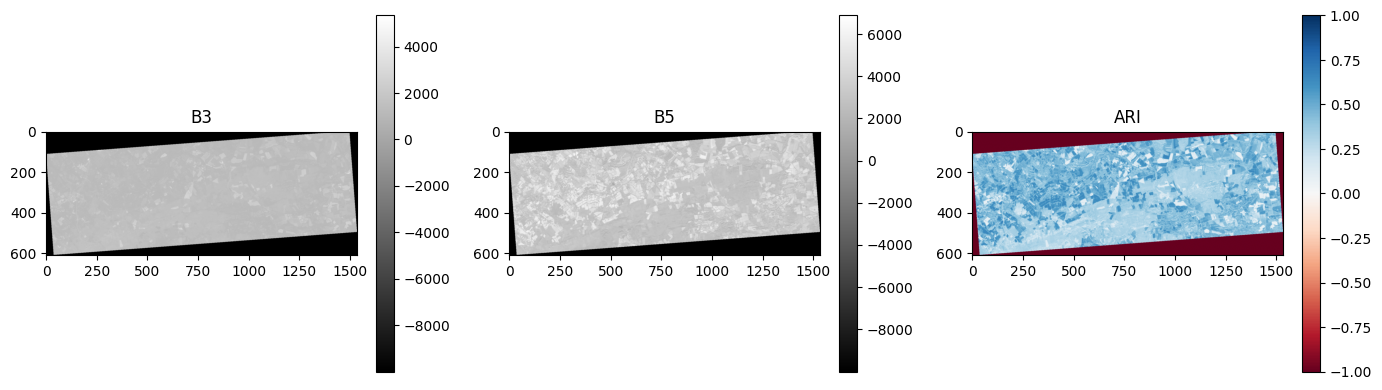

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.imshow(b3, cmap='gray')
plt.title("B3")
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(b5, cmap='gray')
plt.title("B5")
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(ari_test, cmap='RdBu', vmin=-1, vmax=1)
plt.title("ARI")
plt.colorbar()

plt.tight_layout()
plt.show()


In [42]:
def compute_ari_timeseries(B3, B5, nodata=-9999):
    B3 = B3.astype("float32")
    B5 = B5.astype("float32")

    # Masque nodata explicite
    valid = (B3 != nodata) & (B5 != nodata)

    # Masque numérique strict
    epsilon = 1e-6
    valid &= (B3 > epsilon) & (B5 > epsilon)

    ari = np.full(B3.shape, nodata, dtype="float32")

    ari[valid] = (
        (1.0 / B3[valid] - 1.0 / B5[valid]) /
        (1.0 / B3[valid] + 1.0 / B5[valid])
    )

    print(
        "ARI stats:",
        "min =", ari[valid].min(),
        "max =", ari[valid].max(),
        "mean =", ari[valid].mean()
    )

    return ari


In [43]:
import numpy as np
from osgeo import gdal

# Chemin vers une image (une date)
img_path = '/home/onyxia/work/results/bretagne_2023-10-08_fixed.tif'

ds = gdal.Open(img_path)

# Charger les bandes
b3 = ds.GetRasterBand(3).ReadAsArray().astype(np.float32)
b5 = ds.GetRasterBand(5).ReadAsArray().astype(np.float32)

print("B3 shape:", b3.shape)
print("B5 shape:", b5.shape)


B3 shape: (612, 1533)
B5 shape: (612, 1533)


In [44]:
def compute_ari_timeseries(B3, B5, nodata=-9999):
    B3 = B3.astype(np.float32)
    B5 = B5.astype(np.float32)

    # Masque nodata explicite
    valid = (B3 != nodata) & (B5 != nodata)

    # Masque numérique (évite divisions foireuses)
    epsilon = 1e-6
    valid &= (B3 > epsilon) & (B5 > epsilon)

    ari = np.full(B3.shape, nodata, dtype=np.float32)

    ari[valid] = (
        (1.0 / B3[valid] - 1.0 / B5[valid]) /
        (1.0 / B3[valid] + 1.0 / B5[valid])
    )

    print(
        "ARI stats:",
        "min =", ari[valid].min(),
        "max =", ari[valid].max(),
        "mean =", ari[valid].mean()
    )

    return ari


In [45]:
ari = compute_ari_timeseries(b3, b5)


ARI stats: min = -0.16468467 max = 0.68821484 mean = 0.39550665


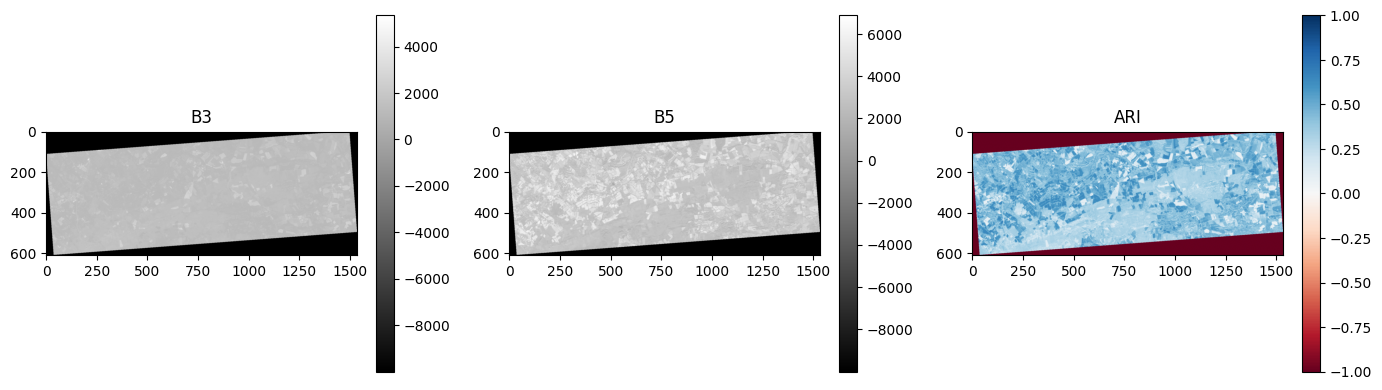

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.imshow(b3, cmap='gray')
plt.title("B3")
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(b5, cmap='gray')
plt.title("B5")
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(ari, cmap='RdBu', vmin=-1, vmax=1)
plt.title("ARI")
plt.colorbar()

plt.tight_layout()
plt.show()


In [47]:
import os
import numpy as np
from osgeo import gdal, osr

# ----------------------------
# Paramètres
# ----------------------------
input_folder = '/home/onyxia/work/results/'
output_folder = '/home/onyxia/work/results/'
os.makedirs(output_folder, exist_ok=True)

dates = ['2023-10-08', '2024-01-19', '2024-04-18', '2024-06-07', '2024-07-19']
nodata = -9999
epsilon = 1e-6

output_ari = os.path.join(output_folder, 'ARI_serie_temp.tif')

# ----------------------------
# Image de référence
# ----------------------------
ref_ds = gdal.Open(os.path.join(input_folder, f'bretagne_{dates[0]}_fixed.tif'))
cols = ref_ds.RasterXSize
rows = ref_ds.RasterYSize
transform = ref_ds.GetGeoTransform()

srs = osr.SpatialReference()
srs.ImportFromEPSG(32630)
projection = srs.ExportToWkt()

# ----------------------------
# Création du raster ARI
# ----------------------------
driver = gdal.GetDriverByName('GTiff')
ari_ds = driver.Create(
    output_ari,
    cols,
    rows,
    len(dates),
    gdal.GDT_Float32
)

ari_ds.SetGeoTransform(transform)
ari_ds.SetProjection(projection)

for i in range(1, len(dates) + 1):
    ari_ds.GetRasterBand(i).SetNoDataValue(nodata)

# ----------------------------
# Calcul ARI pour chaque date
# ----------------------------
for i, date in enumerate(dates):

    print(f"Traitement ARI {date}")

    ds = gdal.Open(os.path.join(input_folder, f'bretagne_{date}_fixed.tif'))

    B3 = ds.GetRasterBand(3).ReadAsArray().astype(np.float32)
    B5 = ds.GetRasterBand(5).ReadAsArray().astype(np.float32)

    valid = (B3 != nodata) & (B5 != nodata)
    valid &= (B3 > epsilon) & (B5 > epsilon)

    ari = np.full(B3.shape, nodata, dtype=np.float32)

    ari[valid] = (
        (1 / B3[valid] - 1 / B5[valid]) /
        (1 / B3[valid] + 1 / B5[valid])
    )

    band = ari_ds.GetRasterBand(i + 1)
    band.WriteArray(ari)
    band.FlushCache()

ari_ds = None
ref_ds = None

print("✅ ARI_serie_temp.tif créé")


Traitement ARI 2023-10-08
Traitement ARI 2024-01-19
Traitement ARI 2024-04-18
Traitement ARI 2024-06-07
Traitement ARI 2024-07-19
✅ ARI_serie_temp.tif créé


---

Test 

In [62]:
path_b03 = f'/home/onyxia/work/data/projet_eval/bretagne_23-24_B03.tif'
path_b05 = f'/home/onyxia/work/data/projet_eval/bretagne_23-24_B05.tif'

ds_b03 = gdal.Open(path_b03)
ds_b05 = gdal.Open(path_b05)

print(f"B03 -> Cols: {ds_b03.RasterXSize}, Lignes: {ds_b03.RasterYSize}")
print(f"B05 -> Cols: {ds_b05.RasterXSize}, Lignes: {ds_b05.RasterYSize}")

if ds_b03.RasterXSize == ds_b05.RasterXSize:
    print("✅ Les dimensions sont identiques. Pas besoin de rééchantillonnage.")
else:
    print("⚠️ Les dimensions sont différentes (Standard Sentinel-2).")

B03 -> Cols: 1533, Lignes: 612
B05 -> Cols: 1533, Lignes: 612
✅ Les dimensions sont identiques. Pas besoin de rééchantillonnage.


In [67]:
# 1. Ouverture du fichier ARI pour servir de modèle de grille
ari_path = os.path.join(results_path, "ARI_serie_temp.tif")
ds_ari = gdal.Open(ari_path)

cols = ds_ari.RasterXSize
rows = ds_ari.RasterYSize
geo_transform = ds_ari.GetGeoTransform()
projection = ds_ari.GetProjection()

# 2. Création d'un raster de destination en mémoire (MEM)
# Il va stocker les codes de classes (1, 2, 3, 4)
mem_driver = gdal.GetDriverByName('MEM')
target_ds = mem_driver.Create('', cols, rows, 1, gdal.GDT_Byte)
target_ds.SetGeoTransform(geo_transform)
target_ds.SetProjection(projection)

# 3. Ouverture du Shapefile avec OGR (et non GDAL)
strates_path = '/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp'
shp_ds = ogr.Open(strates_path)
shp_layer = shp_ds.GetLayer()

# 4. Rasterisation : On "brûle" les polygones dans le raster mémoire
# On suppose que la colonne contenant 1, 2, 3, 4 s'appelle 'id' ou 'classe'
# Vérifie bien le nom de ta colonne !
gdal.RasterizeLayer(target_ds, [1], shp_layer, options=["ATTRIBUTE=id"]) 

# 5. Extraction en tant que matrice Numpy
mask_array = target_ds.GetRasterBand(1).ReadAsArray()

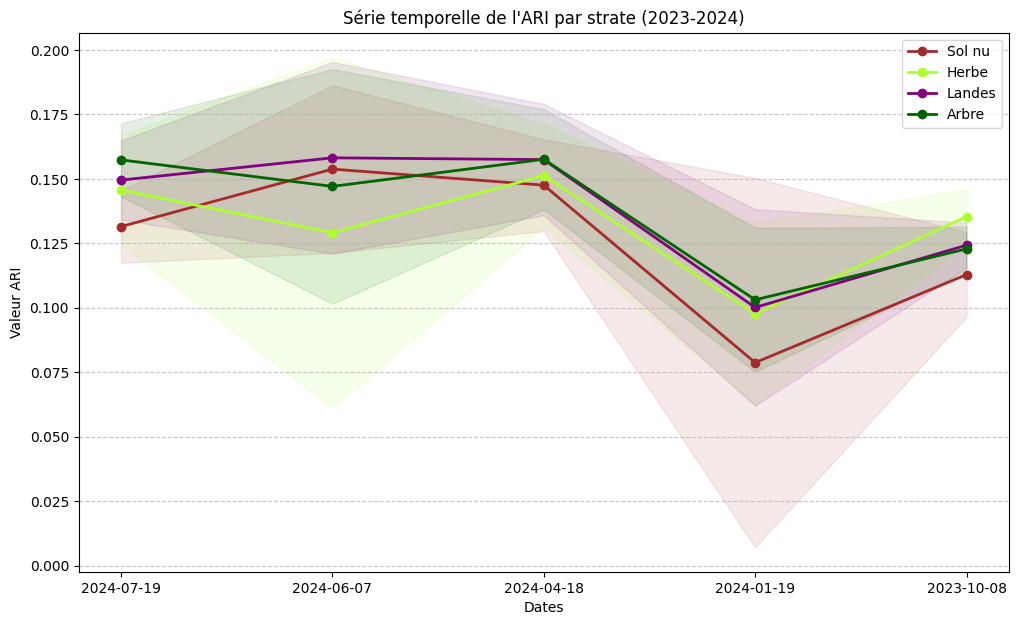

In [68]:
dates = ['2024-07-19', '2024-06-07', '2024-04-18', '2024-01-19', '2023-10-08']
classes = {1: "Sol nu", 2: "Herbe", 3: "Landes", 4: "Arbre"}
colors = {1: "brown", 2: "greenyellow", 3: "purple", 4: "darkgreen"}

plt.figure(figsize=(12, 7))

for code, nom in classes.items():
    means = []
    stds = []
    
    for i in range(len(dates)):
        # On lit la bande correspondant à la date (index i+1 dans GDAL)
        band_data = ds_ari.GetRasterBand(i + 1).ReadAsArray()
        
        # Sélection des pixels de la classe 'code' qui ne sont pas des NoData (-9999)
        valeurs_pixels = band_data[(mask_array == code) & (band_data != -9999)]
        
        if valeurs_pixels.size > 0:
            means.append(np.mean(valeurs_pixels))
            stds.append(np.std(valeurs_pixels))
        else:
            means.append(np.nan)
            stds.append(np.nan)

    # Tracé de la ligne et de l'enveloppe d'écart-type
    plt.plot(dates, means, label=nom, marker='o', color=colors[code], linewidth=2)
    plt.fill_between(dates, 
                     np.array(means) - np.array(stds), 
                     np.array(means) + np.array(stds), 
                     color=colors[code], alpha=0.1)

plt.title("Série temporelle de l'ARI par strate (2023-2024)")
plt.xlabel("Dates")
plt.ylabel("Valeur ARI")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Enregistrement
plt.savefig(os.path.join(figure_path, "ARI_series.png"))
plt.show()

In [69]:
# --- ÉTAPE 1 : ORGANISATION DES DONNÉES EN MÉMOIRE ---
# On définit l'ordre chronologique (du plus vieux au plus récent)
dates_chrono = ['2023-10-08', '2024-01-19', '2024-04-18', '2024-06-07', '2024-07-19']
indices_dans_fichier = [5, 4, 3, 2, 1] # Correspondance avec tes couches TIF

# Dictionnaire pour stocker les résultats ARI par date
ari_results = {}

ds_b03 = gdal.Open('/home/onyxia/work/data/projet_eval/bretagne_23-24_B03.tif')
ds_b05 = gdal.Open('/home/onyxia/work/data/projet_eval/bretagne_23-24_B05.tif')

for i, date in enumerate(dates_chrono):
    idx = indices_dans_fichier[i]
    
    # Lecture directe en mémoire (pas de nouveau fichier sur disque)
    b03 = ds_b03.GetRasterBand(idx).ReadAsArray().astype(np.float32)
    b05 = ds_b05.GetRasterBand(idx).ReadAsArray().astype(np.float32)
    
    # Calcul de l'ARI
    # Note : on gère la division par zéro avec np.where
    with np.errstate(divide='ignore', invalid='ignore'):
        inv_b03 = 1.0 / b03
        inv_b05 = 1.0 / b05
        ari = (inv_b03 - inv_b05) / (inv_b03 + inv_b05)
        
    # On nettoie les valeurs aberrantes (infinités ou NaN)
    ari[~np.isfinite(ari)] = -9999
    
    # On stocke dans notre dictionnaire mémoire
    ari_results[date] = ari

print(f"Calcul terminé pour {len(ari_results)} dates en mémoire vive.")

Calcul terminé pour 5 dates en mémoire vive.


In [70]:
# Rasterisation du shapefile (une seule fois pour toutes les dates)
# ... (utiliser le code de rasterisation précédent pour obtenir mask_array) ...

stats = []
classes_interet = {2: "Herbe", 3: "Landes", 4: "Arbre"}

for date in dates_chrono:
    img_ari = ari_results[date]
    
    for code, nom in classes_interet.items():
        # Extraction des pixels de la classe
        pixels = img_ari[(mask_array == code) & (img_ari != -9999)]
        
        if pixels.size > 0:
            stats.append({
                'Date': date,
                'Classe': nom,
                'Moyenne': np.mean(pixels),
                'Ecart_type': np.std(pixels)
            })

df = pd.DataFrame(stats)

In [71]:
# --- ÉTAPE A : CRÉER LE MASQUE DES CLASSES ---
from osgeo import gdal, ogr

# On utilise B03 pour récupérer la grille (coordonnées, taille)
ref_ds = gdal.Open('/home/onyxia/work/data/projet_eval/bretagne_23-24_B03.tif')
cols, rows = ref_ds.RasterXSize, ref_ds.RasterYSize

# Création du raster en mémoire (MEM)
mem_driver = gdal.GetDriverByName('MEM')
mask_ds = mem_driver.Create('', cols, rows, 1, gdal.GDT_Byte)
mask_ds.SetGeoTransform(ref_ds.GetGeoTransform())
mask_ds.SetProjection(ref_ds.GetProjection())

# Ouverture du shapefile
shp_path = '/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp'
shp_ds = ogr.Open(shp_path)
layer = shp_ds.GetLayer()

# Rasterisation : on brûle la colonne 'id' (ou le nom de ta colonne de classe)
# Assure-toi que le nom de l'attribut est correct (ex: "id", "classe", "code")
gdal.RasterizeLayer(mask_ds, [1], layer, options=["ATTRIBUTE=id"])

mask_array = mask_ds.GetRasterBand(1).ReadAsArray()
print("Masque de classes généré en mémoire.")

Masque de classes généré en mémoire.


In [72]:
# --- ÉTAPE B : CALCUL DES STATS PAR CLASSE ---
import pandas as pd
import numpy as np

stats_list = []
classes_noms = {2: "Herbe", 3: "Landes", 4: "Arbre"}

# ari_results est ton dictionnaire {date: matrice_ari} de l'étape précédente
for date, ari_map in ari_results.items():
    for code, nom in classes_noms.items():
        # Extraction des pixels : on exclut le NoData (-9999)
        pixels = ari_map[(mask_array == code) & (ari_map != -9999)]
        
        if pixels.size > 0:
            stats_list.append({
                'Date': date,
                'Classe': nom,
                'Moyenne': np.mean(pixels),
                'Ecart_type': np.std(pixels)
            })

df_stats = pd.DataFrame(stats_list)
# Conversion de la colonne Date pour un tri chronologique propre
df_stats['Date'] = pd.to_datetime(df_stats['Date'])
df_stats = df_stats.sort_values('Date')

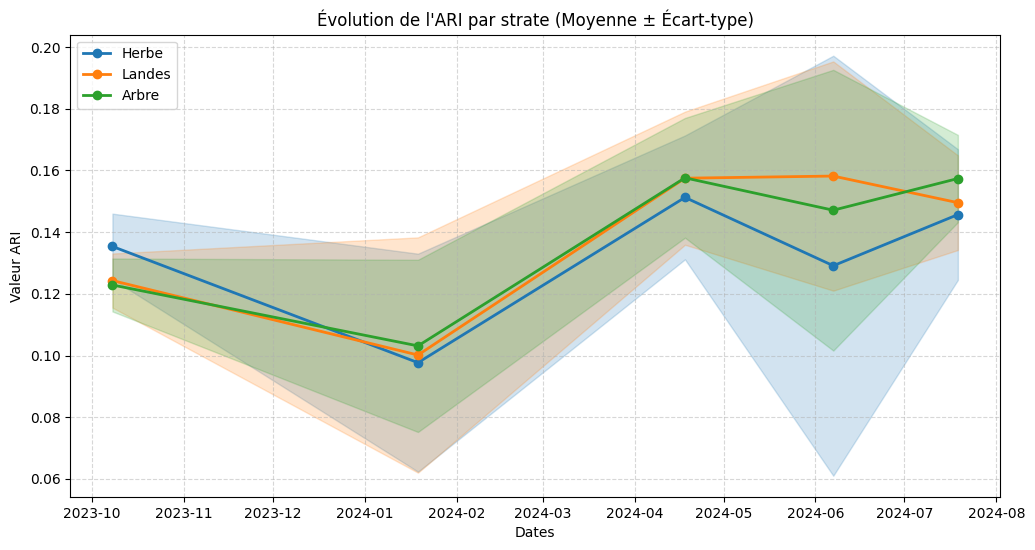

In [73]:
# --- ÉTAPE C : VISUALISATION ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
couleurs = {"Herbe": "tab:blue", "Landes": "tab:orange", "Arbre": "tab:green"}

for nom in classes_noms.values():
    data = df_stats[df_stats['Classe'] == nom]
    
    # Ligne de la moyenne
    plt.plot(data['Date'], data['Moyenne'], label=nom, 
             color=couleurs[nom], marker='o', linewidth=2)
    
    # Ombre de l'écart-type
    plt.fill_between(data['Date'], 
                     data['Moyenne'] - data['Ecart_type'], 
                     data['Moyenne'] + data['Ecart_type'], 
                     color=couleurs[nom], alpha=0.2)

plt.title("Évolution de l'ARI par strate (Moyenne ± Écart-type)")
plt.xlabel("Dates")
plt.ylabel("Valeur ARI")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Sauvegarde
plt.savefig(os.path.join(figure_path, "ARI_series.png"))
plt.show()

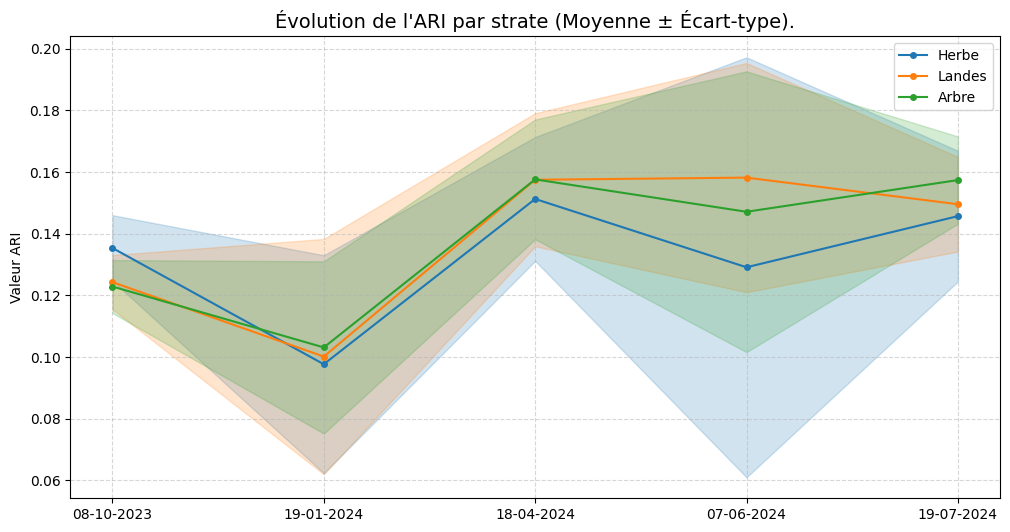

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. Configuration des dates et des bandes (Ordre Chronologique : Octobre -> Juillet)
dates_affichage = ['08-10-2023', '19-01-2024', '18-04-2024', '07-06-2024', '19-07-2024']
indices_bandes = [5, 4, 3, 2, 1] # Bande 5 est Octobre 2023, Bande 1 est Juillet 2024

# 2. Définition des classes à afficher (on ignore la classe 1)
classes_noms = {2: "Herbe", 3: "Landes", 4: "Arbre"}
# Couleurs correspondant à ton image cible
couleurs = {2: "tab:blue", 3: "tab:orange", 4: "tab:green"} 

plt.figure(figsize=(12, 6))

for code, nom in classes_noms.items():
    moyennes = []
    ecarts = []
    
    for idx in indices_bandes:
        # Lecture de la bande ARI correspondante
        # ds_ari doit être ton dataset ouvert du fichier ARI_serie_temp.tif
        band_data = ds_ari.GetRasterBand(idx).ReadAsArray()
        
        # Extraction des pixels (mask_array contient tes échantillons rasterisés)
        pixels = band_data[(mask_array == code) & (band_data != -9999)]
        
        if pixels.size > 0:
            moyennes.append(np.mean(pixels))
            ecarts.append(np.std(pixels))
        else:
            moyennes.append(0)
            ecarts.append(0)

    # Positions sur l'axe X : [0, 1, 2, 3, 4]
    x = np.arange(len(dates_affichage))
    
    # Tracé de la ligne
    plt.plot(x, moyennes, label=nom, color=couleurs[code], marker='o', markersize=4, linewidth=1.5)
    
    # Tracé de l'écart-type (ombre)
    plt.fill_between(x, 
                     np.array(moyennes) - np.array(ecarts), 
                     np.array(moyennes) + np.array(ecarts), 
                     color=couleurs[code], alpha=0.2)

# 3. Personnalisation de l'axe X pour coller au modèle
plt.xticks(ticks=x, labels=dates_affichage)
plt.xlim(-0.2, 4.2) # Pour laisser un peu d'espace sur les bords

# 4. Titres et légende
plt.title("Évolution de l'ARI par strate (Moyenne ± Écart-type).", fontsize=14)
plt.ylabel("Valeur ARI")
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

# 5. Sauvegarde
figure_output = os.path.join(figure_path, "ARI_series.png")
plt.savefig(figure_output, dpi=300, bbox_inches='tight')
plt.show()

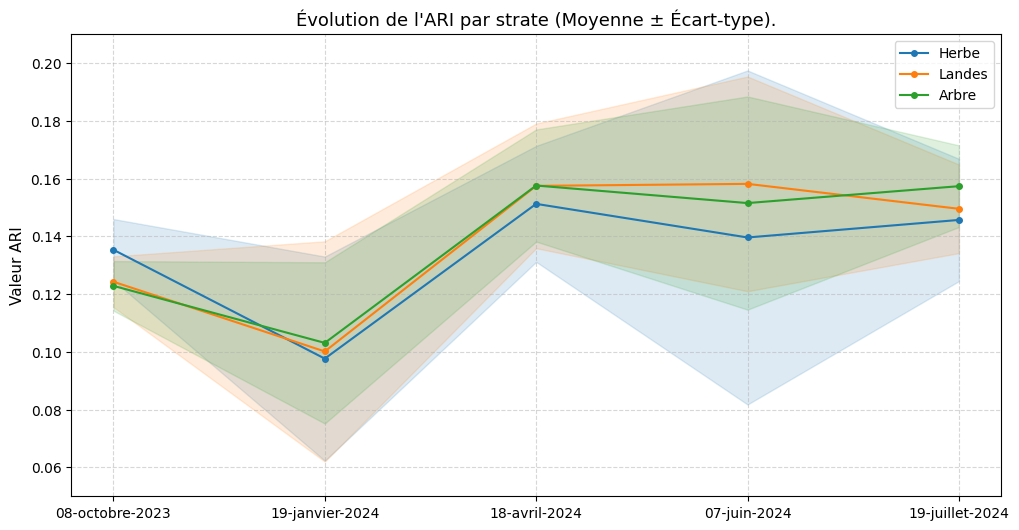

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Configuration des dates (Ordre Chronologique de la cible)
# On définit les étiquettes exactes de la cible
dates_labels = ['08-octobre-2023', '19-janvier-2024', '18-avril-2024', '07-juin-2024', '19-juillet-2024']
# Correspondance des bandes dans tes fichiers (Band 5 = Oct, Band 1 = Juillet)
indices_gdal = [5, 4, 3, 2, 1] 

# 2. Paramétrage des classes (On exclut la classe 1 'Sol nu' comme demandé)
classes_noms = {2: "Herbe", 3: "Landes", 4: "Arbre"}
couleurs = {2: "tab:blue", 3: "tab:orange", 4: "tab:green"} 

plt.figure(figsize=(12, 6))

for code, nom in classes_noms.items():
    moyennes = []
    ecarts = []
    
    for idx in indices_gdal:
        # Lecture de la bande ARI depuis ton fichier calculé
        band_data = ds_ari.GetRasterBand(idx).ReadAsArray()
        
        # Extraction stricte : pixels de la classe ET non nuls ET non NoData
        # On ajoute > 0 pour éviter les pixels noirs qui faussent la moyenne
        mask_classe = (mask_array == code) & (band_data != -9999) & (band_data > 0)
        pixels = band_data[mask_classe]
        
        if pixels.size > 0:
            # On utilise nanmean pour ignorer d'éventuels résidus
            moyennes.append(np.nanmean(pixels))
            ecarts.append(np.nanstd(pixels))
        else:
            moyennes.append(np.nan)
            ecarts.append(np.nan)

    # Axe X catégoriel : 0, 1, 2, 3, 4
    x = np.arange(len(dates_labels))
    
    # Tracé de la ligne (Moyenne)
    plt.plot(x, moyennes, label=nom, color=couleurs[code], marker='o', markersize=4)
    
    # Tracé de l'ombre (Écart-type)
    plt.fill_between(x, 
                     np.array(moyennes) - np.array(ecarts), 
                     np.array(moyennes) + np.array(ecarts), 
                     color=couleurs[code], alpha=0.15)

# --- MISE EN FORME POUR COLLER À LA CIBLE ---
plt.xticks(ticks=x, labels=dates_labels, fontsize=10)
plt.ylabel("Valeur ARI", fontsize=11)
plt.title("Évolution de l'ARI par strate (Moyenne ± Écart-type).", fontsize=13)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0.05, 0.21) # On ajuste l'axe Y comme sur ton image cible

# Sauvegarde
plt.savefig(os.path.join(figure_path, "ARI_series.png"), dpi=300, bbox_inches='tight')
plt.show()

# Production d'une carte de strates à l'échelle du pixel
## Choix du classifieur et sa paramétrisation

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier as RF


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import geopandas as gpd
from osgeo import gdal, ogr, osr


In [ ]:
# Charger le fichier de formes (shapefile) avec les classes
gdf = gpd.read_file('/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp')

# Lire le fichier raster avec les bandes spectrales
dataset = gdal.Open('/home/onyxia/work/results/ARI_serie_temp.tif')
band_count = dataset.RasterCount

# Initialiser les listes pour stocker les données et les étiquettes
X = []
y = []

# Créer un système de coordonnées basé sur EPSG:32630
srs = osr.SpatialReference()
srs.ImportFromEPSG(32630)

# Parcourir chaque polygone dans le shapefile
for index, row in gdf.iterrows():
    # Récupérer la géométrie du polygone
    geom = row['geometry']

    # Créer un masque pour le polygone
    mem_drv = ogr.GetDriverByName('Memory')
    mem_ds = mem_drv.CreateDataSource('out')
    mem_layer = mem_ds.CreateLayer('poly', srs=srs, geom_type=ogr.wkbPolygon)

    # Créer une feature et définir sa géométrie
    feature = ogr.Feature(mem_layer.GetLayerDefn())
    ogr_geom = ogr.CreateGeometryFromWkb(geom.wkb)
    feature.SetGeometry(ogr_geom)
    mem_layer.CreateFeature(feature)
    feature = None

    # Créer un raster en mémoire pour le masque
    target_ds = gdal.GetDriverByName('MEM').Create('', dataset.RasterXSize, dataset.RasterYSize, 1, gdal.GDT_Byte)
    target_ds.SetGeoTransform(dataset.GetGeoTransform())
    target_ds.SetProjection(srs.ExportToWkt())
    band = target_ds.GetRasterBand(1)
    band.Fill(0)
    band.SetNoDataValue(0)

    # Rasteriser le polygone
    gdal.RasterizeLayer(target_ds, [1], mem_layer, burn_values=[1])

    # Lire le masque rasterisé
    mask_array = band.ReadAsArray()

    # Extraire les valeurs des bandes spectrales pour les pixels dans le polygone
    for band_num in range(1, band_count + 1):
        band = dataset.GetRasterBand(band_num)
        band_array = band.ReadAsArray()

        # Extraire les valeurs des pixels qui sont dans le masque
        pixel_values = band_array[mask_array == 1]
        valid_pixels = pixel_values[pixel_values != -9999]

        # Ajouter les valeurs des bandes pour chaque pixel valide
        if band_num == 1:
            X_temp = valid_pixels.reshape(-1, 1)
        else:
            X_temp = np.column_stack((X_temp, valid_pixels))

    # Ajouter les étiquettes de classe pour chaque pixel valide
    if 'X_temp' in locals():
        X.extend(X_temp)
        y.extend([row['strate']] * len(X_temp))

# Convertir X et y en tableaux numpy
X = np.array(X)
y = np.array(y)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Forme de X_train:", X_train.shape)
print("Forme de y_train:", y_train.shape)
print("Forme de X_test:", X_test.shape)
print("Forme de y_test:", y_test.shape)


In [ ]:
# Initialiser le modèle RandomForest
rf = RandomForestClassifier(random_state=0)

# Définition de la grille d'hyperparamètres
param_grid = {
    "n_estimators": [50, 100, 150, 200, 300],  # Nombre d'arbres dans la forêt
    "max_depth": [None, 10, 15, 20],     # Profondeur maximale des arbres
    "max_features": [None, "sqrt", "log2"], # Nombre de variables testées à chaque split
    "min_samples_leaf": [1, 5]       # Nombre minimal d’échantillons dans une feuille
}

# Cross-validation stratifiée avec K=5
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Grille de recherche
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1  # utilise tous les CPU pour aller plus vite
)

# Entraînement avec recherche des meilleurs hyperparamètres
grid.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres trouvés :")
print(grid.best_params_)

# Score moyen de la cross-validation
print(f"Score CV moyen : {grid.best_score_:.2f}")

# Modèle final (entraîné sur tout le train)
best_model = grid.best_estimator_

# Évaluation sur le test
y_pred = best_model.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)

print(f"Accuracy test : {acc_test:.2f}")

# Afficher un rapport de classification détaillé
from sklearn.metrics import classification_report
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))


**Interprétation des résultats** :

max_depth : 20 : Les arbres ont une profondeur maximale de 20.

max_features : sqrt : Le modèle utilise la racine carrée du nombre total de caractéristiques à chaque division.

min_samples_leaf : 1 : Chaque feuille peut contenir un seul échantillon.

n_estimators : 300 : Le modèle utilise 300 arbres.

---

Classe 2 : Précision de 0.98 et rappel de 0.97.

Classe 3 : Précision de 0.94 et rappel de 0.93.

Classe 4 : Précision de 0.89 et rappel de 0.91.


### Stratégie de validation

Les classes ici sont relativement équilibrées (respectivement 1044, 1545 et 1229 pixels pour les classes 2, 3 et 4). Le type de validation choisi est donc le StratifiedKFold qui permet de conserver la proportion des classes, rendant cette méthode indispensable dans le cas de classes déséquilibrées. Bien que relativement équilibrées, les classes de cette étude ne le sont pas parfaitement. Ainsi, afin d'éviter un biais, le type de validation choisi est le StratifiedKFold. 

Le jeu de données ayant une taille modérée (3818 pixels), la valeur de K choisie est 5, afin que la stratégie de validation soit à la fois robuste et moins coûteuse en temps. 



In [ ]:
# Charger le fichier de formes (shapefile) avec les classes
gdf = gpd.read_file('/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp')

# Lire le fichier raster avec les bandes spectrales
dataset = gdal.Open('/home/onyxia/work/results/.tif')
band_count = dataset.RasterCount

# Initialiser les listes pour stocker les données et les étiquettes
X = []
y = []

# Créer un système de coordonnées basé sur EPSG:32630
srs = osr.SpatialReference()
srs.ImportFromEPSG(32630)

# Parcourir chaque polygone dans le shapefile
for index, row in gdf.iterrows():
    # Récupérer la géométrie du polygone
    geom = row['geometry']

    # Créer un masque pour le polygone
    mem_drv = ogr.GetDriverByName('Memory')
    mem_ds = mem_drv.CreateDataSource('out')
    mem_layer = mem_ds.CreateLayer('poly', srs=srs, geom_type=ogr.wkbPolygon)

    # Créer une feature et définir sa géométrie
    feature = ogr.Feature(mem_layer.GetLayerDefn())
    ogr_geom = ogr.CreateGeometryFromWkb(geom.wkb)
    feature.SetGeometry(ogr_geom)
    mem_layer.CreateFeature(feature)
    feature = None

    # Créer un raster en mémoire pour le masque
    target_ds = gdal.GetDriverByName('MEM').Create('', dataset.RasterXSize, dataset.RasterYSize, 1, gdal.GDT_Byte)
    target_ds.SetGeoTransform(dataset.GetGeoTransform())
    target_ds.SetProjection(srs.ExportToWkt())
    band = target_ds.GetRasterBand(1)
    band.Fill(0)
    band.SetNoDataValue(0)

    # Rasteriser le polygone
    gdal.RasterizeLayer(target_ds, [1], mem_layer, burn_values=[1])

    # Lire le masque rasterisé
    mask_array = band.ReadAsArray()

    # Extraire les valeurs des bandes spectrales pour les pixels dans le polygone
    for band_num in range(1, band_count + 1):
        band = dataset.GetRasterBand(band_num)
        band_array = band.ReadAsArray()

        # Extraire les valeurs des pixels qui sont dans le masque
        pixel_values = band_array[mask_array == 1]
        valid_pixels = pixel_values[pixel_values != -9999]

        # Ajouter les valeurs des bandes pour chaque pixel valide
        if band_num == 1:
            X_temp = valid_pixels.reshape(-1, 1)
        else:
            X_temp = np.column_stack((X_temp, valid_pixels))

    # Ajouter les étiquettes de classe pour chaque pixel valide
    if 'X_temp' in locals():
        X.extend(X_temp)
        y.extend([row['strate']] * len(X_temp))

# Convertir X et y en tableaux numpy
X = np.array(X)
y = np.array(y)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Forme de X_train:", X_train.shape)
print("Forme de y_train:", y_train.shape)
print("Forme de X_test:", X_test.shape)
print("Forme de y_test:", y_test.shape)
